In [70]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import copy

import awkward as ak
import uproot
import matplotlib
import matplotlib.pyplot as plt
import mplcyberpunk
import numpy as np

from rich import print
from particle import Particle
from scipy.interpolate import interp1d

from python.analysis import Master, Plots, cross_section, vector, Fitting

def hist_glow(alpha = 0.03, n = 5, width = 1.05):
    ax = plt.gca()
    for patch in ax.get_children()[:-1]: # last patch in children is the grid
        if type(patch) not in [matplotlib.patches.Polygon, matplotlib.patches.Rectangle]: continue # only add glow to histogram patches
        for i in range(1, n + 1):
            new_patch = copy.copy(patch)

            if new_patch.get_edgecolor() == (0, 0, 0, 0):
                edgecolor = new_patch.get_facecolor()
            else:
                edgecolor = new_patch.get_edgecolor()

            new_patch.set(alpha = alpha, linewidth = new_patch.get_linewidth() + (width * i), edgecolor = edgecolor, facecolor = new_patch.get_facecolor(), zorder = 0.6) # grid lines are hardcoded at zorder 0.5
            ax.add_patch(new_patch)


def truth_regions(events : Master.Data) -> dict:
    """ masks to select particle which interact in a particular channel or "region". these truth regions reflect the channels defined in the simulation.

    Args:
        events (Master.Data): events to look at.

    Returns:
        dict: dictionary of masks.
    """
    inelastic = events.trueParticles.true_beam_endProcess == "pi+Inelastic"
    absorption = inelastic & (events.trueParticles.nPiPlus == 0) & (events.trueParticles.nPi0 == 0) & (events.trueParticles.nPiMinus == 0)
    cex = (events.trueParticles.nPiPlus == 0) & (events.trueParticles.nPi0 == 1) & (events.trueParticles.nPiMinus == 0)
    quasielastic = (events.trueParticles.nPiPlus == 1) & (events.trueParticles.nPi0 == 0) & (events.trueParticles.nPiMinus == 0)
    double_cex = (events.trueParticles.nPiPlus == 0) & (events.trueParticles.nPi0 == 0) & (events.trueParticles.nPiMinus == 1)
    pion_production = inelastic & (~absorption) & (~cex) & (~quasielastic) & ~(double_cex)
    return {"total_inelastic" : inelastic, "absorption" : absorption, "charge_exchange" : cex, "quasielastic" : quasielastic, "double_charge_exchange" : double_cex, "pion_production" : pion_production}


def EsliceDemo(events : Master.Data, e_min : float, e_max : float, e_width : float):
    """ Demonstation on how to use the EnergySlice to compute cross sections using MC truth.

    Args:
        events (Master.Data): events to look at
        e_min (float): minimum energy range
        e_max (float): maximum energy range
        e_width (float): energy slice width
    """
    cross_sections = cross_section.GeantCrossSections(energy_range = [e_min, e_max]) # get cross sections from simulation

    energy_slices = cross_section.Slices(e_width, e_min, e_max, reversed = True) # define energy slices

    #* true interacting kinetic energy
    true_int_KE = events.trueParticles.beam_traj_KE[:, -2] # -1 is always zero for kinetic energy trajectory points, to take -2

    #* true front facing kinetic energy
    true_ffKE = ak.where(events.trueParticles.KE_front_face < 0, 999999, events.trueParticles.KE_front_face) # set KE to 999999 if the particle didn't reach the TPC.
    outside_tpc = true_ffKE >= 999999 # don't count events outside the TPC

    mean_dEdX = cross_section.EnergySlice.Slice_dEdX(energy_slices, Particle.from_pdgid(211)) # dEdX at each energy slice

    #* evalutate and plot for each exclusive cross section
    regions = truth_regions(events) # get truth regions
    for i, region in Plots.IterMultiPlot(regions):
        print(f"evaluating {region} region")
        n_interact, n_incident = cross_section.EnergySlice.CountingExperiment(true_int_KE, true_ffKE, outside_tpc, regions[region], energy_slices)
        xs = cross_section.EnergySlice.CrossSection(n_interact, n_incident, mean_dEdX, energy_slices.width)
        Plots.Plot(energy_slices.pos[1:], xs[0][1:], yerr = xs[1][1:], xerr = energy_slices.width/2, marker = "x", linestyle = "", newFigure = False, label = "MC truth", xlabel = "KE (MeV)", ylabel = "$\sigma$(mb)")
        cross_sections.Plot(region, label = "Geant4 simulation", color = "C6", title = f"{region}: {ak.sum(regions[region])}")
        plt.xlim(e_min - e_width, e_max + e_width)


def ThinSliceDemo(events : Master.Data, z_range : list, e_range : list, slice_width : float):
    """ Demonstation on how to use the ThinSlice to compute cross sections using MC truth.

    Args:
        events (Master.Data): events to look at
        z_range (list): spatial slice range
        e_range (list): energy range
        slice_width (float): spatial slice width
    """
    cross_sections = cross_section.GeantCrossSections(energy_range = e_range) # get cross sections from simulation

    slices = cross_section.Slices(slice_width, min(z_range), max(z_range)) # define spatial slices

    interact_position = events.trueParticles.endPos.z[:, 0] # get interaction vertex z position

    traj_KE = events.trueParticles.beam_traj_KE # get beam particle kinetic energy at each trajectory point from simulation
    traj_pos = events.trueParticles.beam_traj_pos.z # get beam particle z at each trajectory point from simulation 

    regions = truth_regions(events) # get trtuh regions
    mean_slice_energy, mean_error_slice_energy = cross_section.ThinSlice.MeanSliceEnergy(traj_KE[regions["total_inelastic"]], traj_pos[regions["total_inelastic"]], slices) # get average particle energy in each slice

    #* evalutate and plot for each exclusive cross section
    for i, region in Plots.IterMultiPlot(regions):
        print(f"evaluating {region} region")

        n_interact, n_incident = cross_section.ThinSlice.CountingExperiment(interact_position, regions[region], slices)
        xs = cross_section.ThinSlice.CrossSection(n_incident, n_interact, slices.width/ 0.95)
        Plots.Plot(mean_slice_energy[1:-1], xs[0][1:-1], yerr = xs[1][1:-1], xerr = mean_error_slice_energy[1:-1], xlabel = "average $\pi^{+}$ kinetic energy before interacting (MeV)", ylabel = "$\sigma$(mb)", linestyle = "", marker = "x", newFigure = False, label = "MC truth")
        cross_sections.Plot(region, label = "Geant4 simulation", color = "C6", title = f"{region}: {ak.sum(regions[region])}")
        plt.xlim(min(e_range), max(e_range))


def LoadSample(file : str, nEvents : int) -> Master.Data:
    """ Load root file and select only true pions.

    Args:
        file (str): root file
        nEvents (int): number of events

    Returns:
        Master.Data: true pion events
    """
    events = Master.Data(file, nTuple_type = Master.Ntuple_Type.PDSP, nEvents = nEvents)

    mask = events.trueParticles.pdg[:, 0] == 211
    events.Filter([mask], [mask])

    return events


cross_section.SetPlotStyle(dpi = 140, extend_colors = True)
# plt.style.use("cyberpunk")
# plt.rcParams["figure.dpi"] = 140

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


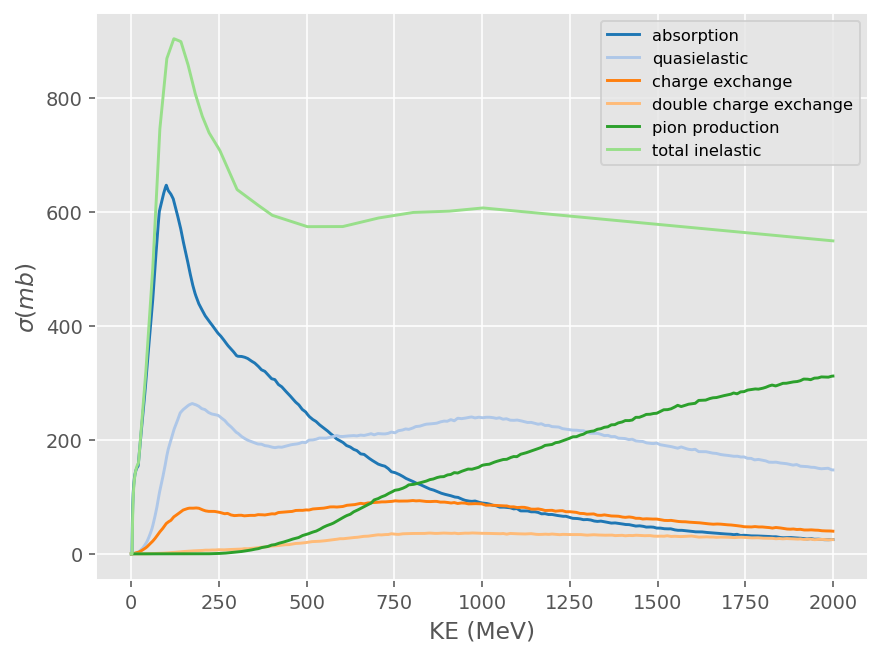

In [5]:
cross_sections = cross_section.GeantCrossSections(energy_range = [0, 2000])
cross_sections.Plot("all")
# mplcyberpunk.add_glow_effects()

In [42]:
events = LoadSample("work/ROOTFiles/PDSPAnalyser/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03.root", -1)#149097
# events = LoadSample("work/ROOTFiles/PDSPAnalyser/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03.root", 70774)#70774

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to nTuple_type.
  warnings.warn(f"Couldn't apply filters to {var}.")


# Slices based on position

can slice up a TPC into thin slice targets based on the collection wire spacing.

By the conventions used by others, a single slice contains 20 wires, so is 10cm in thinkness (collection plane wire pitch is 5mm)

In [59]:
slices = cross_section.Slices(10, -10, 720)

Now we do the counting experiment. the cross section in a single slice is:
$$
    \sigma = \frac{M_{Ar}}{\rho t N_{A}}\log\left( \frac{N_{incident}}{N_{incident} - N_{interact}} \right)
$$

 - $t$ is the thickness of each slice
 - $N_{incident}$ is the number of incident beam particles in the slice
 - $N_{interact}$ is the number of interacting beam particles in the slice (i.e. the end of the beam particle trajectory)

Alrogithm to count $N_{indicent}$ and $N_{interact}$ is as follows:

 1. Create `N_{indicent}` and `N_{interact}` bins for each slice.
 1. loop over each beam particle and find the end trajectory point
 2. calculate which slice the end trajectory point falls in `end_slice = floor(z/t)`
 3. add 1 to `end_slice` in `N_{interact}` bins and add 1 to every slice before and including `end_slice` in `N_{indicent}` (this makes the assumption the beam particle travelled through every slice before the final one.)


n_interact=array([9422, 7543, 6668, 5792, 5005, 4255, 3839, 3453, 2889, 2486, 2226,
       1906, 1677, 1423, 1277, 1147, 1033,  884,  770,  709,  605,  559,
        504,  430,  386,  326,  287,  245,  200,  187,  178,  152,  102,
         77,   61,   55,   18,   15,    5,    3,    1,    0,    1,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0])

n_incident=array([71941, 60872, 53207, 46444, 40565, 35474, 31151, 27250, 23749,
       20815, 18291, 16022, 14081, 12369, 10906,  9605,  8435,  7376,
        6473,  5677,  4953,  4325,  3752,  3233,  2792,  2391,  2058,
        1754,  1491,  1277,  1074,   875,   697,   563,   437,   327,
         222,   152,    92,    53,    26,    13,     4,     1,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])

Text(0.5, 0, 'interaction vertex z(cm)')

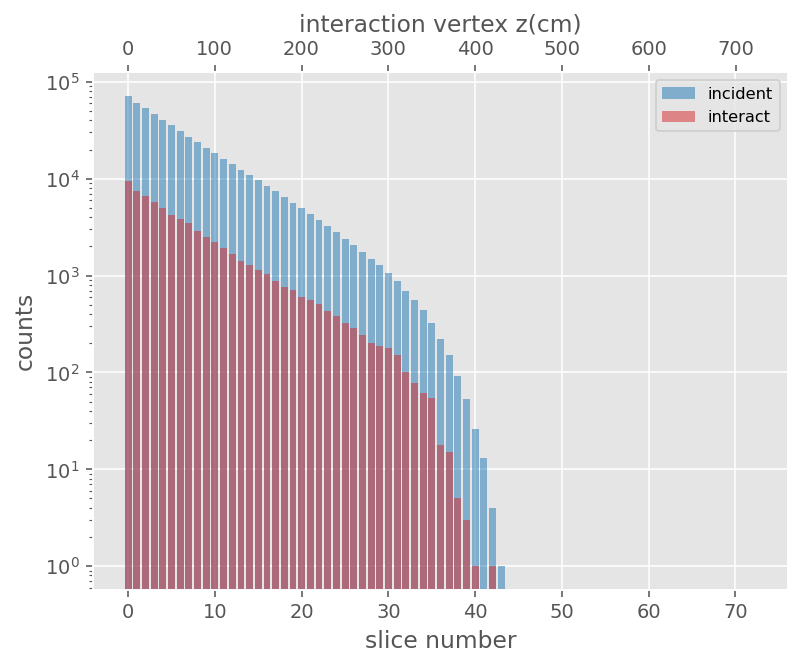

In [60]:
regions = truth_regions(events)
n_interact, n_incident = cross_section.ThinSlice.CountingExperiment(events.trueParticles.endPos.z[:, 0], regions["total_inelastic"], slices) # using trajectory points gives wierd results, compare the two to see what is different.

print(f"{n_interact=}")
print(f"{n_incident=}")

plt.bar(slices.num[1:], n_incident, alpha = 0.5, label = "incident")
plt.bar(slices.num[1:], n_interact, alpha = 0.5, label = "interact", color = "C6")
plt.yscale("log")
plt.xlabel("slice number")
plt.ylabel("counts")
plt.legend()

def f(x):
    return (x + 0.5) * slices.width

def g(x):
    return x // slices.width

sax = plt.gca().secondary_xaxis("top", functions = (f, g))
sax.set_xlabel("interaction vertex z(cm)")


Plot the cross section as a function of slice number

/tmp/ipykernel_18900/934252342.py:267: RuntimeWarning: invalid value encountered in divide
  xs = np.log(n_incident / (n_incident - n_interact)) # calculate a dimensionless cross section
/tmp/ipykernel_18900/934252342.py:270: RuntimeWarning: invalid value encountered in divide
  v_interact = n_interact*(1- (n_interact/n_incident)) # binomial uncertainty
/tmp/ipykernel_18900/934252342.py:272: RuntimeWarning: divide by zero encountered in divide
  xs_e = (1/n_incident) * (1/(n_incident - n_interact)) * (n_interact**2 * v_incident + n_incident**2 * v_interact)**0.5


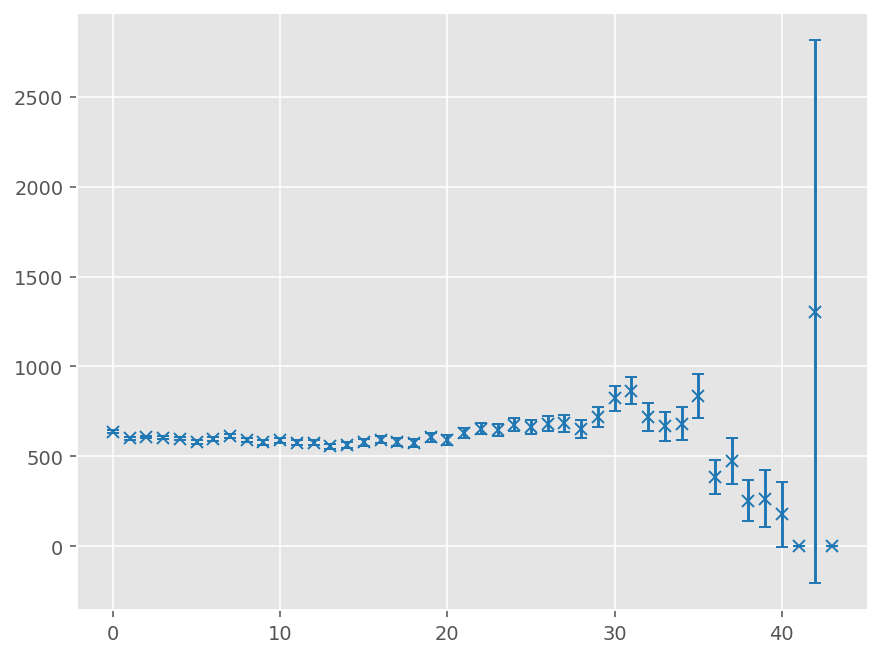

In [61]:
xs = cross_section.ThinSlice.CrossSection(n_incident, n_interact, slices.width/0.95)
Plots.Plot(slices.num[1:-1], xs[0][:-1], yerr = xs[1][:-1], marker = "x", linestyle = "")

Plot the cross section as a function of the avergae $\pi^{+}$ Kinetic energy in each slice

In [62]:
def MPSliceEnergy(events : Master.Data, slices : cross_section.Slices):
    nums = slices.pos_to_num(events.trueParticles.beam_traj_pos.z[:, :-1])

    mpv = []
    mpv_e = []
    for i in range(1, len(slices.num)):
        sample = nums == slices[i].num
        h, e = np.histogram(ak.ravel(events.trueParticles.beam_traj_KE[:, :-1][sample]), 100)
        c = (e[1:] + e[:-1]) / 2
        mpv.append(c[np.argmax(h)])
        mpv_e.append(abs((e[0] - e[1]) / 2))
    return np.array(mpv), np.array(mpv_e)


def MedianSliceEnergy(events : Master.Data, slices : cross_section.Slices):
    nums = slices.pos_to_num(events.trueParticles.beam_traj_pos.z[:, :-1])

    median = []
    median_e = []
    for i in range(1, len(slices.num)):
        sample = nums == slices[i].num
        h, e = np.histogram(ak.ravel(events.trueParticles.beam_traj_KE[:, :-1][sample]), 100)
        c = (e[1:] + e[:-1]) / 2
        median.append(c[np.argmax(h)])
        median_e.append(np.std(ak.ravel(events.trueParticles.beam_traj_KE[:, :-1][sample]) / np.sqrt(ak.sum(sample))))
    return np.array(median), np.array(median_e)

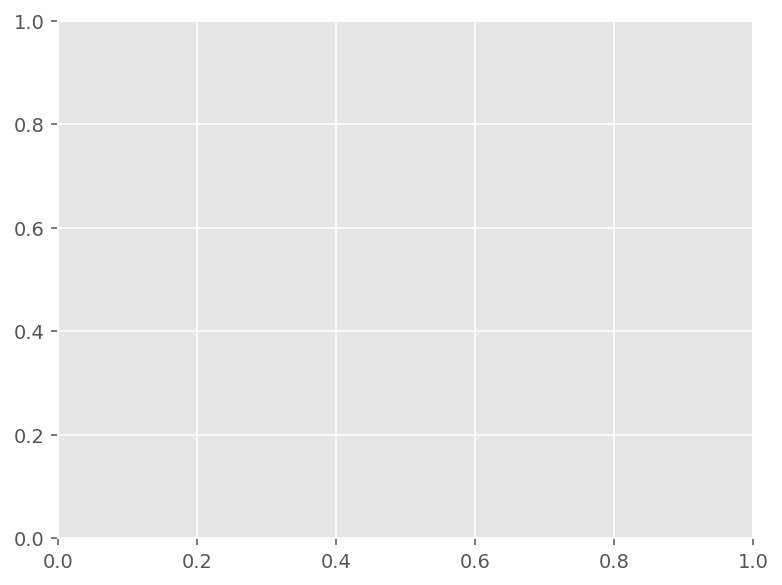

In [76]:
import matplotlib.backends.backend_pdf


with matplotlib.backends.backend_pdf.PdfPages("thin_slice_true_energies_1GeV.pdf") as pdf:
    nums = slices.pos_to_num(events.trueParticles.beam_traj_pos.z[:, :-1])

    for i in range(len(slices.num)):
        sample = nums == slices[i].num
        Plots.PlotHist(ak.ravel(events.trueParticles.beam_traj_KE[:, :-1][sample]), title = slices[i], xlabel = "KE (MeV)", range = [0, 1000])
        plt.xlim(0, 1000)
        pdf.savefig()
        plt.close()
        plt.cla()

    for i in Plots.MultiPlot(len(slices.num)):
        sample = nums == slices[i].num
        Plots.PlotHist(ak.ravel(events.trueParticles.beam_traj_KE[:, :-1][sample]), title = slices[i], xlabel = "KE (MeV)", range = [0, 1000], newFigure = False)
        plt.xlim(0, 1000)
    pdf.savefig()
    plt.close()
    plt.cla()


/tmp/ipykernel_18900/934252342.py:249: RuntimeWarning: invalid value encountered in divide
  mean_energy = sum_energy / counts
/tmp/ipykernel_18900/934252342.py:251: RuntimeWarning: invalid value encountered in divide
  std_energy = np.sqrt(sum_energy_sqr/counts - 2 * mean_energy * sum_energy / counts + mean_energy**2) # expanded standard deviation so I can calulcate using the histograms


Text(0.5, 0, 'interaction vertex z(cm)')

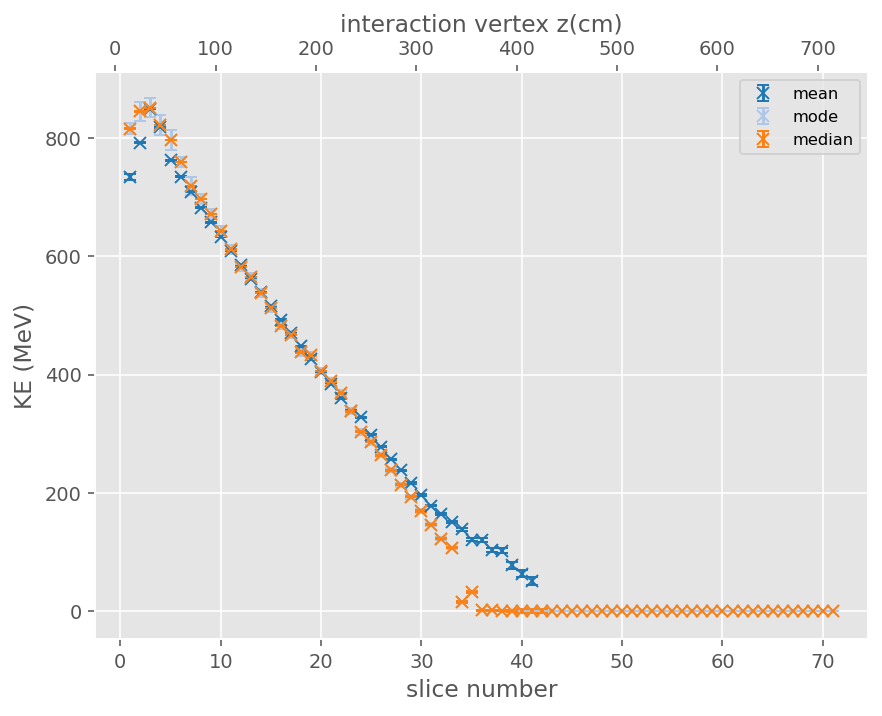

In [63]:
mean_energy = cross_section.ThinSlice.MeanSliceEnergy(events.trueParticles.beam_traj_KE[regions["total_inelastic"]], events.trueParticles.beam_traj_pos.z[regions["total_inelastic"]], slices)

mpv_energy = MPSliceEnergy(events, slices)
medain_energy = MedianSliceEnergy(events, slices)

plt.figure()
for e, l in zip([mean_energy, mpv_energy, medain_energy], ["mean", "mode", "median"]):
    Plots.Plot(slices.num[2:-1], e[0][1:-1], yerr = e[1][1:-1], marker = "x", linestyle = "", xlabel = "slice number", label = l, ylabel = "KE (MeV)", newFigure = False)
sax = plt.gca().secondary_xaxis("top", functions = (f, g))
sax.set_xlabel("interaction vertex z(cm)")

(0.0, 1200.0)

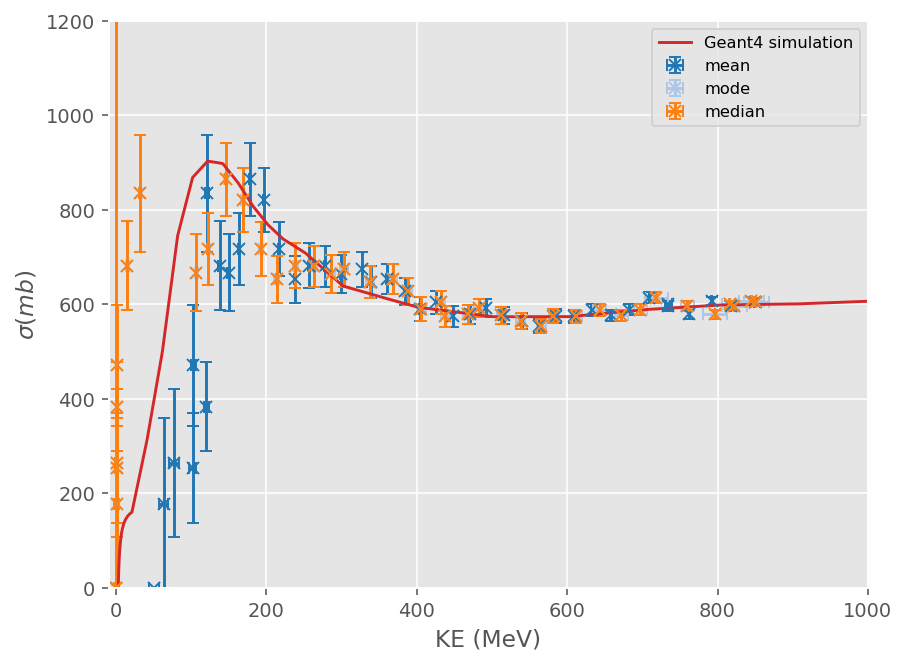

In [70]:
valid = slice(1, -1, 1)
plt.figure()
cross_sections.Plot("total_inelastic", color = "C6", label = "Geant4 simulation")
for e, l in zip([mean_energy, mpv_energy, medain_energy], ["mean", "mode", "median"]):
    Plots.Plot(e[0][valid], xs[0][valid], xerr = e[1][valid], yerr = xs[1][valid], marker = "x", linestyle = "", label = l, newFigure = False)

plt.xlim(-10, 1000)
plt.ylim(0, 1200)

(0.0, 1200.0)

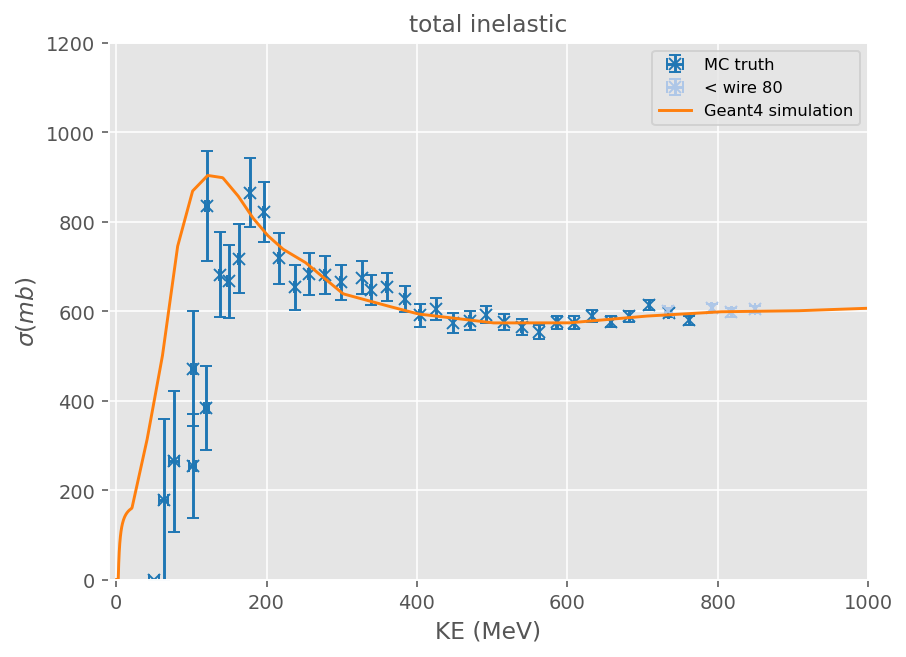

In [64]:
valid = slice(5, -1, 1) # past slice 5 (wire 80), there are issues with space charge effects in reco, so I highlighted them in this example, but for MC truth shouldn't be an issue.
low_wire = slice(1, 5, 1)

Plots.Plot(mean_energy[0][valid], xs[0][valid], xerr = mean_energy[1][valid], yerr = xs[1][valid], marker = "x", linestyle = "", label = "MC truth")
Plots.Plot(mean_energy[0][low_wire], xs[0][low_wire], xerr = mean_energy[1][low_wire], yerr = xs[1][low_wire], marker = "x", linestyle = "", label = "< wire 80", newFigure = False)
cross_sections.Plot("total_inelastic", color = "C2", label = "Geant4 simulation")

plt.xlim(-10, 1000)
plt.ylim(0, 1200)

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:529: RuntimeWarning: invalid value encountered in divide
  mean_energy = sum_energy / counts
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:531: RuntimeWarning: invalid value encountered in divide
  std_energy = np.divide(sum_energy_sqr, counts) - mean_energy**2


evaluating total_inelastic region

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:549: RuntimeWarning: invalid value encountered in divide
  xs = np.log(n_incident / (n_incident - n_interact)) # calculate a dimensionless cross section
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:552: RuntimeWarning: invalid value encountered in divide
  v_interact = n_interact*(1- (n_interact/n_incident)) # binomial uncertainty
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:554: RuntimeWarning: divide by zero encountered in divide
  xs_e = (1/n_incident) * (1/(n_incident - n_interact)) * (n_interact**2 * v_incident + n_incident**2 * v_interact)**0.5


evaluating absorption region

evaluating charge_exchange region

evaluating quasielastic region

evaluating double_charge_exchange region

evaluating pion_production region

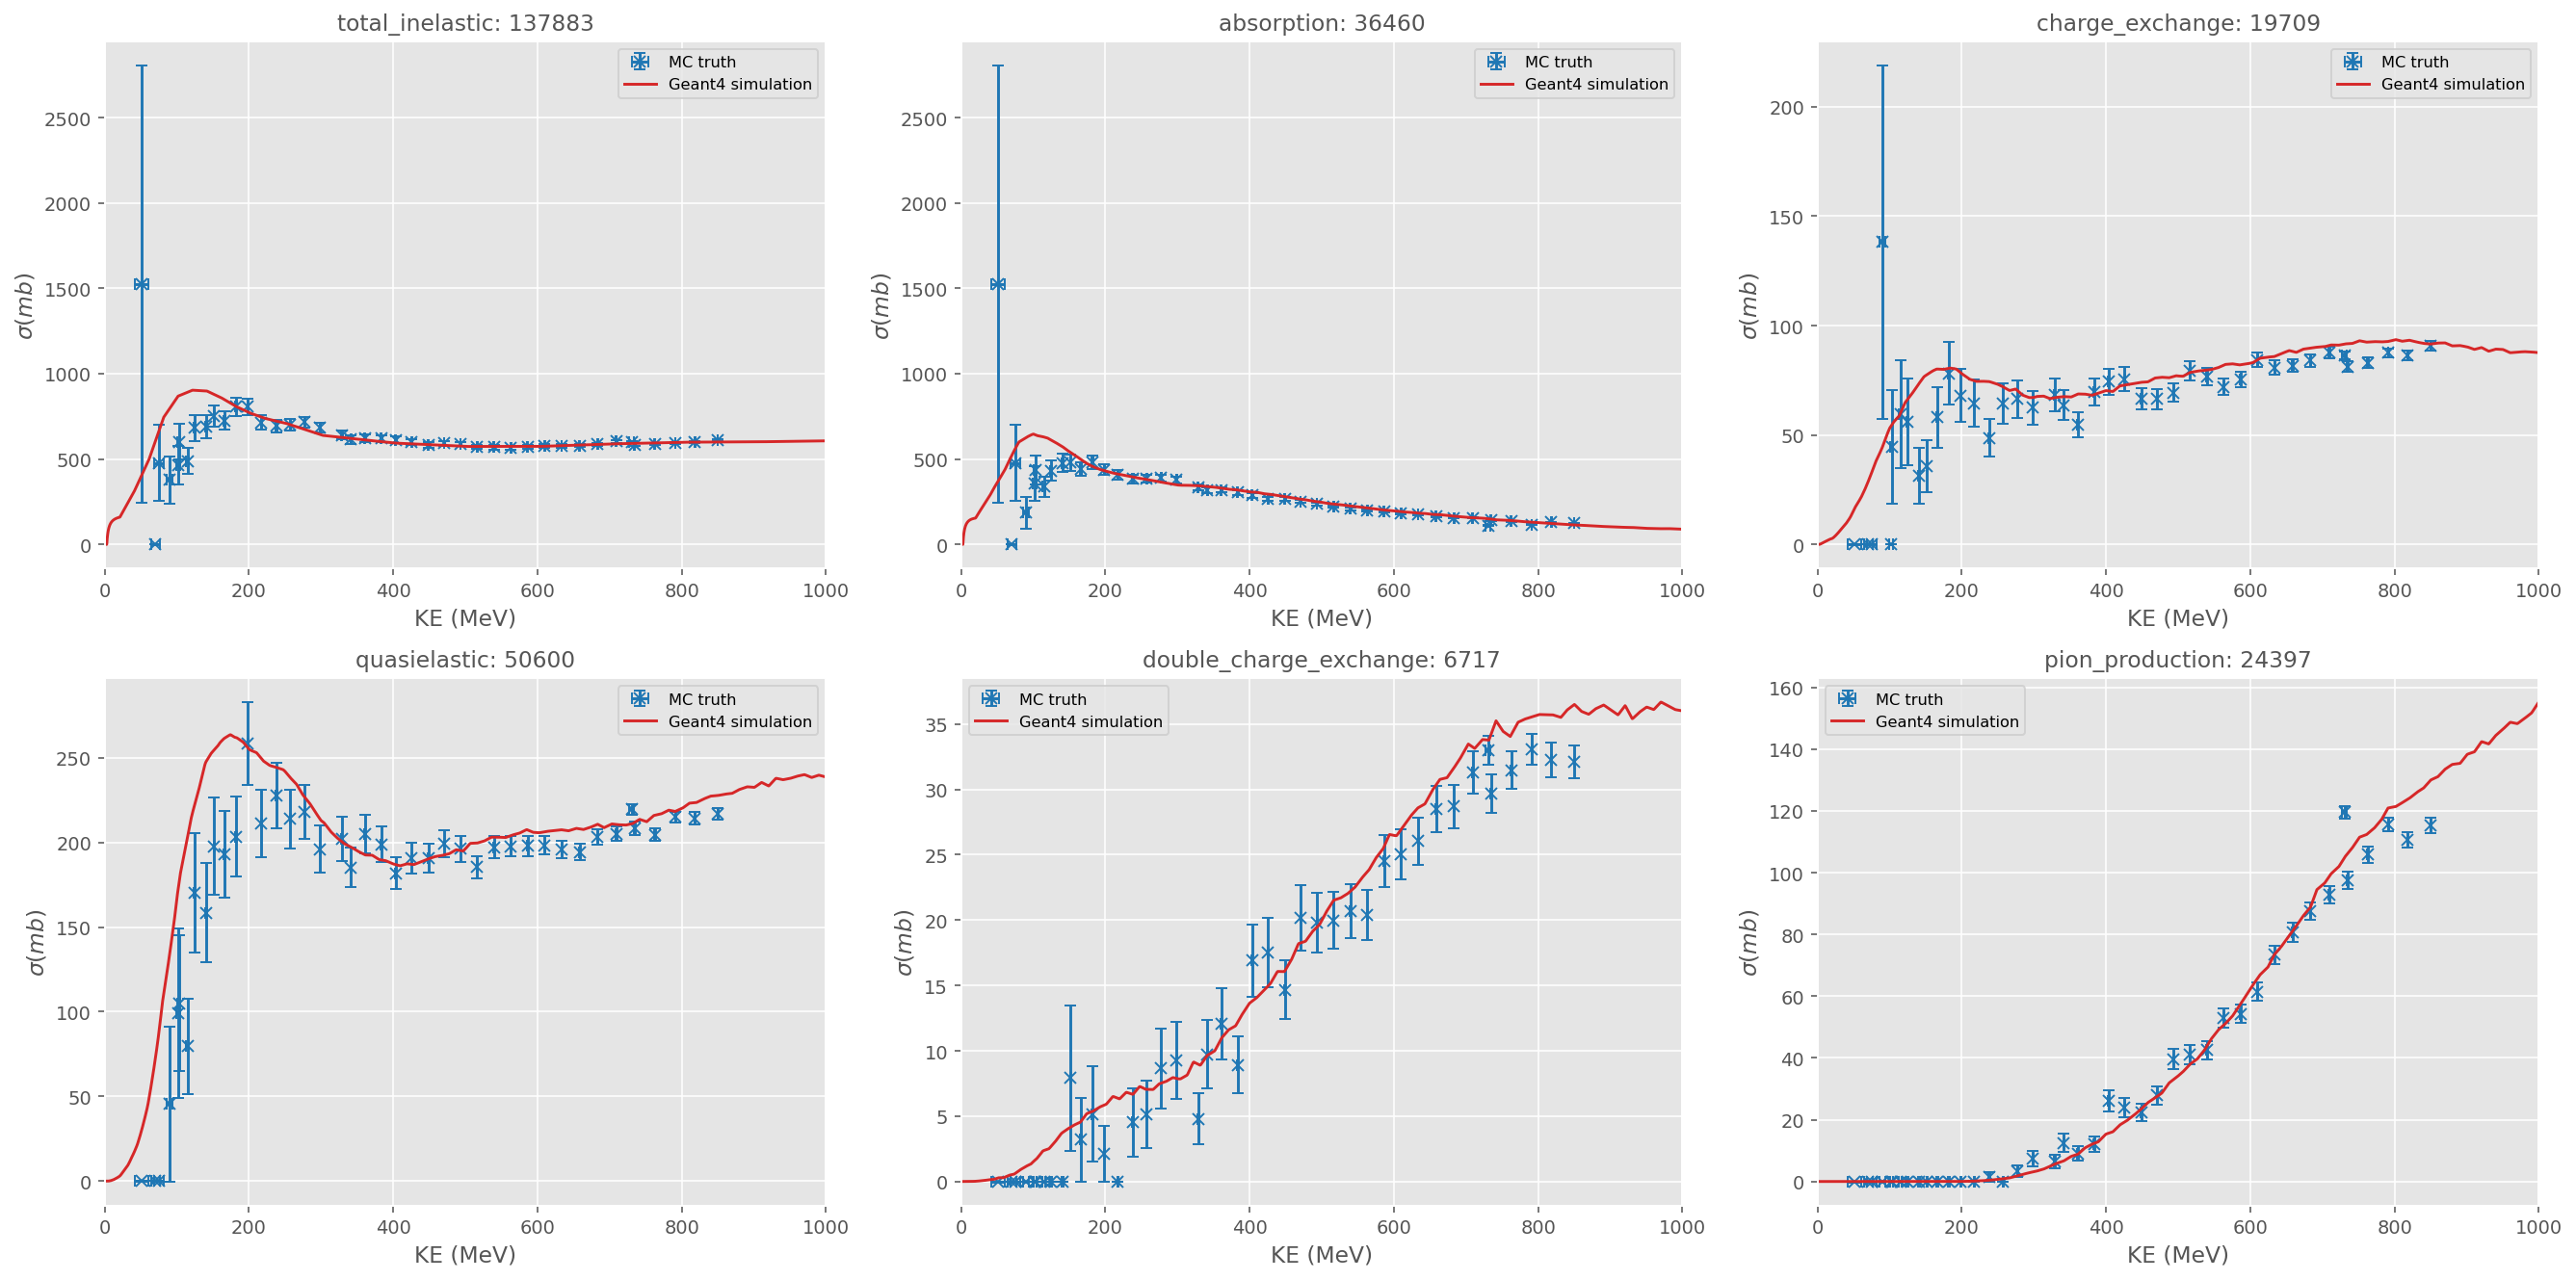

In [71]:
ThinSliceDemo(events, [-10, 720], [0, 1000], 10)

# plt.setp(plt.gcf().axes[0], xlim = [1000, 2000], ylim = [0, 800])
# plt.setp(plt.gcf().axes[1], xlim = [1000, 2000], ylim = [0, 250])
# plt.setp(plt.gcf().axes[2], xlim = [1000, 2000], ylim = [0, 200])
# plt.setp(plt.gcf().axes[3], xlim = [1000, 2000], ylim = [0, 400])

# plt.setp(plt.gcf().axes[-1], ylim = [0, 200])


In [98]:
for i, s in Plots.IterMultiPlot(slices):
    mask = slices.pos_to_num(events.trueParticles.beam_traj_pos.z) == s.num
    energy = events.trueParticles.true_beam_traj_KE[mask]
    Plots.PlotHist(ak.ravel(energy), newFigure = False, title = s.__str__(), range = [0, 1500], xlabel = "True Kinetic Energy (MeV)")

# Slices Based on Energy

instead of computing the slices based on the wire pitch, use the energy loss of the particle and define slices in energy instead. This means the slice thickness is now in terms of $\delta E$ and the spacial thickness is:

$$
    t_{i} = \frac{\delta E}{ \left.\frac{dE}{dX}\right|_{\left< E_{i} \right>} }
$$

where i is the slice number, $dE/dX$ is the energy loss per unit length and $E_{i}$ is the particle energy exiting the slice.

i.e. the slice thickness is the distance the particle travels before it looses $\delta E$ worth of energy.

Now the cross section formula becomes:

$$
\sigma_{i} = \frac{M_{Ar}}{\rho N_{A} \delta E} \left.\frac{dE}{dX}\right|_{\left< E_{i} \right>} \log\left( \frac{N_{incident}}{N_{incident} - N_{interact}} \right)
$$

And really is a function of the particle kinetic energy rather than the averge kinetic energy in a slice.

By convention, $\delta E$ is set to 50MeV (not sure why) and now the slice thickness need to be calculated per particle

Now, the counting will work in a similar way, but we can no longer assume the particle travels through all slices because the initial kinetic energy of the beam particle vill vary. So as well as the end slice, an initial slice must be found.

The initial slice is `ceil((plim - KE_ini)//dE)`

The end slice is still the last trajectory point, but the slice number needs to be found based on the energy the particle had before interacting with the target

870.1225800481984

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:154: RuntimeWarning: invalid value encountered in double_scalars
  beta = (1 - (1/gamma)**2)**0.5


-44.135129713718406

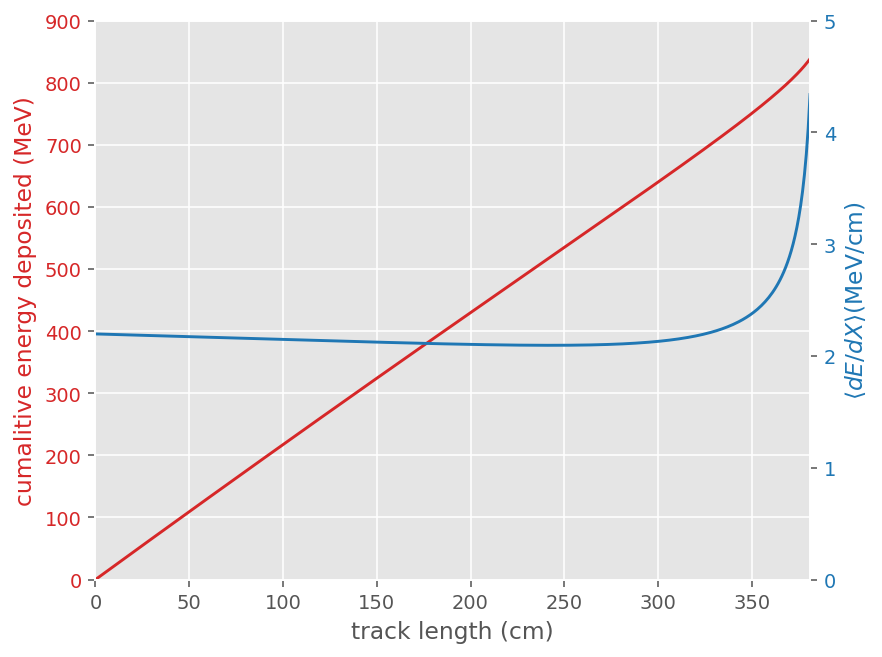

In [83]:
KE = ((1000)**2 + (Particle.from_pdgid(211).mass)**2)**0.5 - Particle.from_pdgid(211).mass
print(KE)
total_energy_deposited = [0]
dEdX = [cross_section.BetheBloch.meandEdX(KE, Particle.from_pdgid(211))]

pitch = 1 # cm

while KE > 0:
    total_energy_deposited.append(total_energy_deposited[-1] + dEdX[-1] * pitch)
    KE -= dEdX[-1] * pitch
    dEdX.append(cross_section.BetheBloch.meandEdX(KE, Particle.from_pdgid(211)))
print(KE)

total_energy_deposited = np.array(total_energy_deposited)
dEdX = np.array(dEdX)

trk_len = np.arange(0, pitch * len(dEdX), pitch)

dEdX = dEdX[trk_len <= 381]
total_energy_deposited = total_energy_deposited[trk_len <= 381]
trk_len = trk_len[trk_len <= 381]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('track length (cm)')
ax1.set_ylabel('cumalitive energy deposited (MeV)', color=color)
ax1.plot(trk_len, total_energy_deposited, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel("$\left<dE/dX\\right>$(MeV/cm)", color=color)  # we already handled the x-label with ax1
ax2.plot(trk_len, dEdX, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(False)

ax1.set_ylim(0, 900)
ax2.set_ylim(0, 5)
plt.xlim(0, 381)

fig.tight_layout()  # otherwise the right y-label is slightly clipped


(2.0, 5.2)

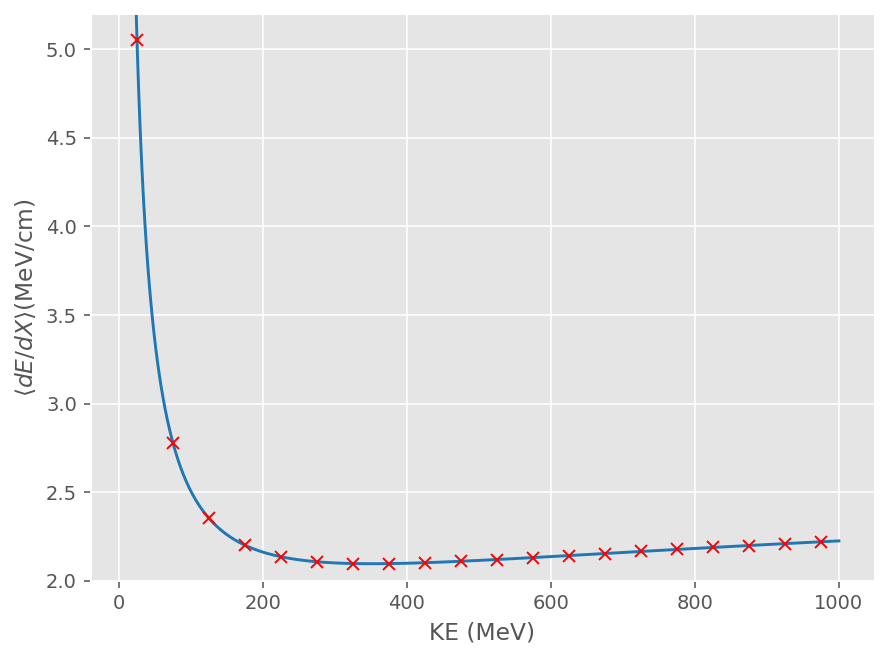

In [84]:
Plots.Plot(np.logspace(1, 3, 100), cross_section.BetheBloch.meandEdX(np.logspace(1, 3, 100), Particle.from_pdgid(211)))
Plots.Plot(np.arange(0, 1000, 50) + 25, cross_section.BetheBloch.meandEdX(np.arange(0, 1000, 50) + 25, Particle.from_pdgid(211)), marker = "x", color = "red", newFigure = False, linestyle = "", xlabel = "KE (MeV)", ylabel = "$\left<dE/dX\\right>$(MeV/cm)")
plt.ylim(2, 5.2)

In [117]:
def ff_KE():
    """ Calculate the true front facing kinetic energy.
        If the particle never reaches the TPC, it is assigned 999999.
        Note this method gives a larger kinetic enrgy than if you interpolate between the fist and last points (not sure why).

    Returns:
        ak.Array: true front facing kinetic energy
    """
    ind = ak.argmax(events.trueParticles.beam_traj_pos.z > 0, 1, keepdims = True) # first trajectory point in the TPC

    dist = vector.dist(events.trueParticles.beam_traj_pos[ind], events.trueParticles.beam_traj_pos[ind-1]) # distance from the first point in the TPC and last point outside the TPC

    dist = dist * events.trueParticles.beam_traj_pos.z[ind] / (events.trueParticles.beam_traj_pos.z[ind] - events.trueParticles.beam_traj_pos.z[ind - 1]) # weight the dist by the ratios of z to get the distance from the front face of the TPC (slighly more accurate than just doing z[i] - z[i-1])

    f_KE = events.trueParticles.beam_traj_KE[ind] # get the kinetic energy at the first trajectory point
    f_KE = ak.where(ak.flatten(events.trueParticles.beam_traj_pos.z[ind] < 0), 999999, f_KE) # set first KE to zero if the particle didn't reach the TPC.

    dEdX = cross_section.BetheBloch.meandEdX(f_KE, Particle.from_pdgid(211)) # mean dEdX to extrapolate the front facing Kinetic energy
    return ak.flatten(f_KE + dist * dEdX)

true_int_KE = events.trueParticles.beam_traj_KE[:, -2] # -1 is always zero for kinetic energy trajectory points, to take -2

true_ffKE = ak.where(events.trueParticles.KE_front_face < 0, 999999, events.trueParticles.KE_front_face) ## set KE to 999999 if the particle didn't reach the TPC.
# true_ffKE = ff_KE() #! see function comments

energy_slices = cross_section.Slices(20, 0, 2000, reversed = True)

print(f"{true_int_KE=}")
print(f"{true_ffKE=}")

true_int_KE=<Array [1.82e+03, 1.56e+03, ... 1.81e+03] type='44169 * float64'>

true_ffKE=<Array [1.83e+03, 1.73e+03, ... 1.82e+03] type='44169 * ?float64'>

np.unique(true_init_slice, return_counts=True)=(array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10, 
11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  36,  38,  39,
        40,  41,  42,  45,  51,  52,  53,  55,  60,  61,  62,  64,  67,
        69,  70,  71,  72,  73,  74,  75,  77,  78,  80,  81,  82,  83,
        84,  85,  86,  87,  89,  92,  93,  95,  97,  99, 100]), array([6477, 1360, 1629, 2014, 2192, 2522, 2499, 
2592, 2754, 2738, 2716,
       2518, 2326, 2095, 1895, 1460, 1139,  829,  643,  479,  358,  222,
        182,  119,   78,   63,   44,   34,   14,   15,   11,    6,    5,
          1,    4,    3,    3,    2,    1,    2,    2,    1,    2,    2,
          1,    1,    2,    1,    1,    1,    1,    1,    3,    2,    3,
          1,    1,    4,    2,    1,    1,    2,    4,    3,    3,    5,
          3,    1,    2,    4,    1,    1,    2,    1,    1,   58]))

np.unique(true_int_slice, return_counts=True)=(array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  
11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  98, 100]), array([3419,  494,  568,  716,  894,  971, 1206, 1388, 1560, 
1544, 1639,
       1791, 1801, 1870, 1783, 1874, 1731, 1585, 1514, 1432, 1373, 1262,
       1030, 1030,  955,  825,  785,  658,  601,  572,  535,  438,  436,
        358,  335,  318,  295,  253,  237,  196,  179,  162,  135,  127,
        132,  114,   97,  102,   63,   82,   57,   61,   50,   42,   34,
         42,   43,   35,   19,   33,   34,   15,   17,   14,    6,   15,
         13,    6,   11,   11,   11,    7,   10,    3,    7,    3,    3,
          1,    6,    9,    4,    5,    6,    6,    3,    4,    7,    3,
          2,    3,    7,    1,    1,    3,    3,    4,    4,    4,    1,
         15]))

Text(0.5, 0, 'KE (MeV)')

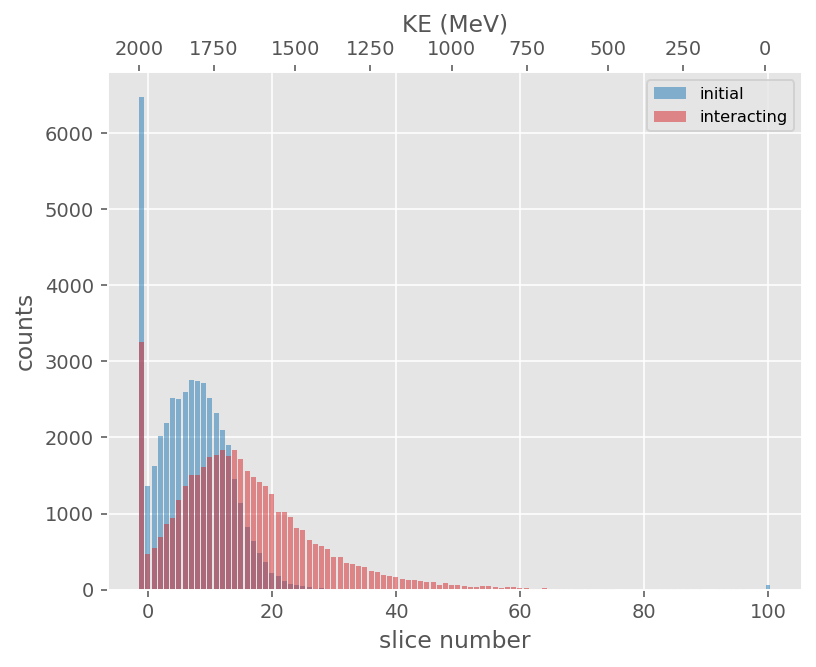

In [118]:
regions = truth_regions(events)

true_init_slice = energy_slices(true_ffKE).num + 1 # equivilant to ceil
true_int_slice = energy_slices(true_int_KE).num

true_init_slice = cross_section.EnergySlice.TrunacteSlices(true_init_slice, energy_slices)
true_int_slice = cross_section.EnergySlice.TrunacteSlices(true_int_slice, energy_slices)

# just in case we encounter an instance where E_int > E_ini (unphysical)
bad_slices = true_int_slice < true_init_slice
true_init_slice = ak.where(bad_slices < 0, -1, true_init_slice)
true_int_slice = ak.where(bad_slices, -1, true_int_slice)

print(f"{np.unique(true_init_slice, return_counts=True)=}")
print(f"{np.unique(true_int_slice, return_counts=True)=}")

plt.bar(*np.unique(true_init_slice, return_counts = True), alpha = 0.5, label = "initial")
plt.bar(*np.unique(true_int_slice[regions["total_inelastic"]], return_counts = True), alpha = 0.5, color = "C6", label = "interacting")
plt.xlabel("slice number")
plt.ylabel("counts")
plt.legend()

def f(x):
    return (energy_slices.max_num - x - 1.5) * energy_slices.width

def g(x):
    return ((energy_slices.max - x) // energy_slices.width) + 1.5

sax = plt.gca().secondary_xaxis("top", functions = (f, g))
sax.set_xlabel("KE (MeV)")

[ 3517  4691  6165  7687  9381 10955 12394 13806 15050 16256 17178 17762
 18074 18125 17831 17125 16280 15390 14394 13356 12225 11172 10284  9343
  8463  7682  6936  6295  5715  5157  4631  4200  3767  3415  3084  2766
  2474  2221  1987  1792  1615  1455  1321  1194  1063   951   854   753
   691   609   553   494   444   403   370   332   289   256   237   205
   171   157   141   129   125   111    98    93    83    77    70    67
    58    56    52    51    49    50    45    36    34    33    31    31
    32    31    26    25    23    24    18    17    18    16    14    14
    10     8     8     8     8]

[ 347  436  553  705  799 1011 1170 1337 1353 1441 1598 1640 1716 1650
 1755 1618 1478 1423 1360 1321 1220  986 1006  931  810  771  647  593
  563  530  433  431  353  330  315  291  250  232  195  179  160  135
  127  128  113   94  101   62   81   54   60   50   40   33   39   43
   33   19   32   33   14   16   12    5   14   13    6   10    9    9
    6   10    3    7    3    2    0    6    9    4    5    5    2    3
    3    6    3    2    2    6    1    0    3    2    2    4    2    0
    1    0 2923]

Text(0.5, 0, 'KE (MeV)')

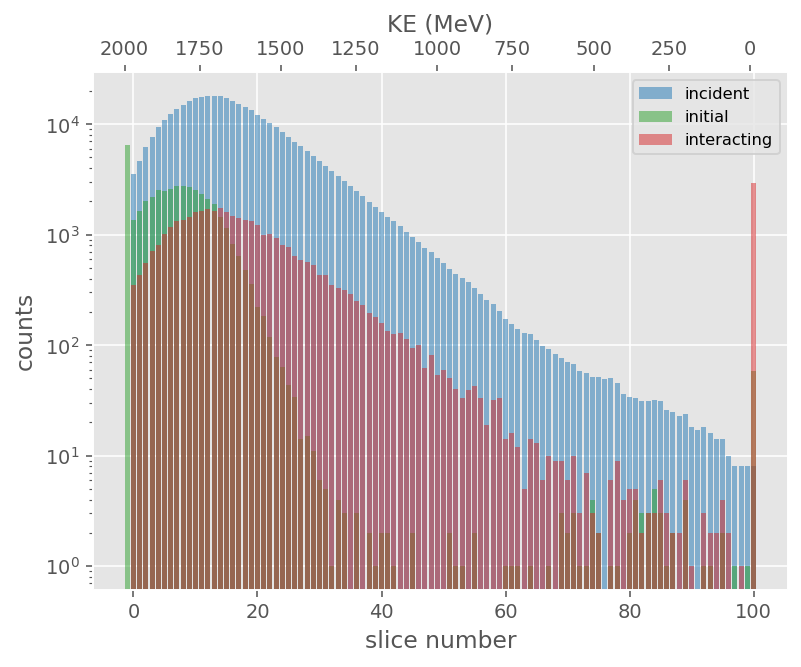

In [119]:
outside_tpc = true_ffKE >= 999999 # don't count events outside the TPC
n_interact, n_incident = cross_section.EnergySlice.CountingExperiment(true_int_KE, true_ffKE, outside_tpc, regions["total_inelastic"], energy_slices)

print(n_incident)
print(n_interact)

plt.bar(energy_slices.num, n_incident, alpha = 0.5, label = "incident")
plt.bar(*np.unique(true_init_slice, return_counts = True), color = "C4", alpha = 0.5, label = "initial")
plt.bar(energy_slices.num, n_interact, alpha = 0.5, color = "C6", label = "interacting")
plt.xlabel("slice number")
plt.ylabel("counts")
plt.yscale("log")
plt.legend()

def f(x):
    return (energy_slices.max_num - x - 1.5) * energy_slices.width

def g(x):
    return ((energy_slices.max - x) // energy_slices.width) + 1.5

sax = plt.gca().secondary_xaxis("top", functions = (f, g))
sax.set_xlabel("KE (MeV)")


/tmp/ipykernel_35413/1320162809.py:300: RuntimeWarning: invalid value encountered in log
  xs = np.log(n_incident / (n_incident - n_interact)) # calculate a dimensionless cross section


(0.0, 1200.0)

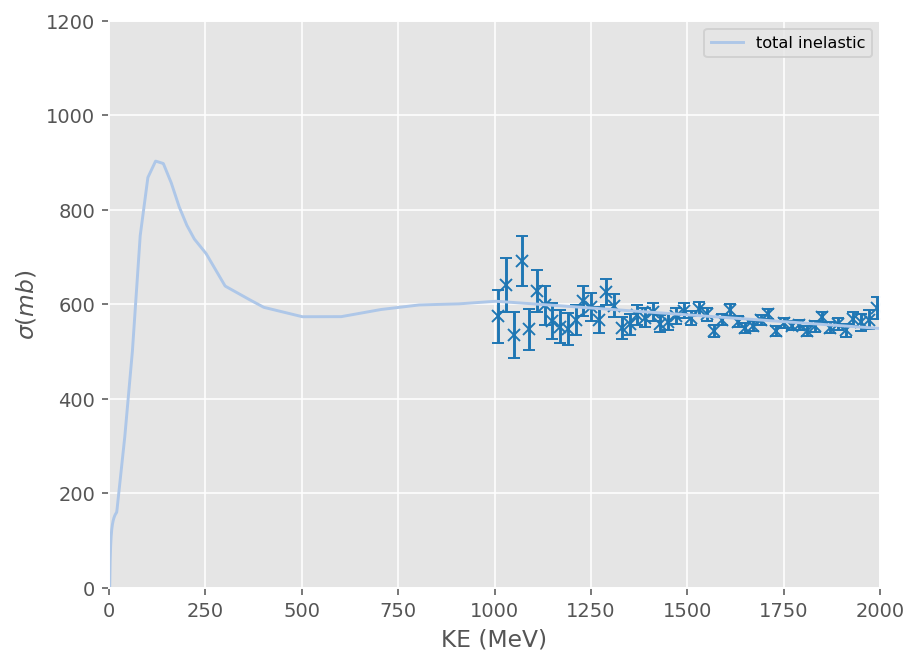

In [455]:
dEdX = cross_section.EnergySlice.Slice_dEdX(energy_slices, Particle.from_pdgid(211))
xs = cross_section.EnergySlice.CrossSection(n_interact, n_incident, dEdX, energy_slices.width)

Plots.Plot(energy_slices.pos - energy_slices.width/2, xs[0], yerr = xs[1], marker = "x", linestyle = "")

cross_sections.Plot("total_inelastic")
plt.xlim(0, energy_slices.max)
plt.ylim(0, 1200)

In [68]:
print( (cross_section.BetheBloch.meandEdX(40, Particle.from_pdgid(211))/40)**-1 )

10.586429084369557

evaluating total_inelastic region

evaluating absorption region

evaluating charge_exchange region

evaluating quasielastic region

evaluating double_charge_exchange region

evaluating pion_production region

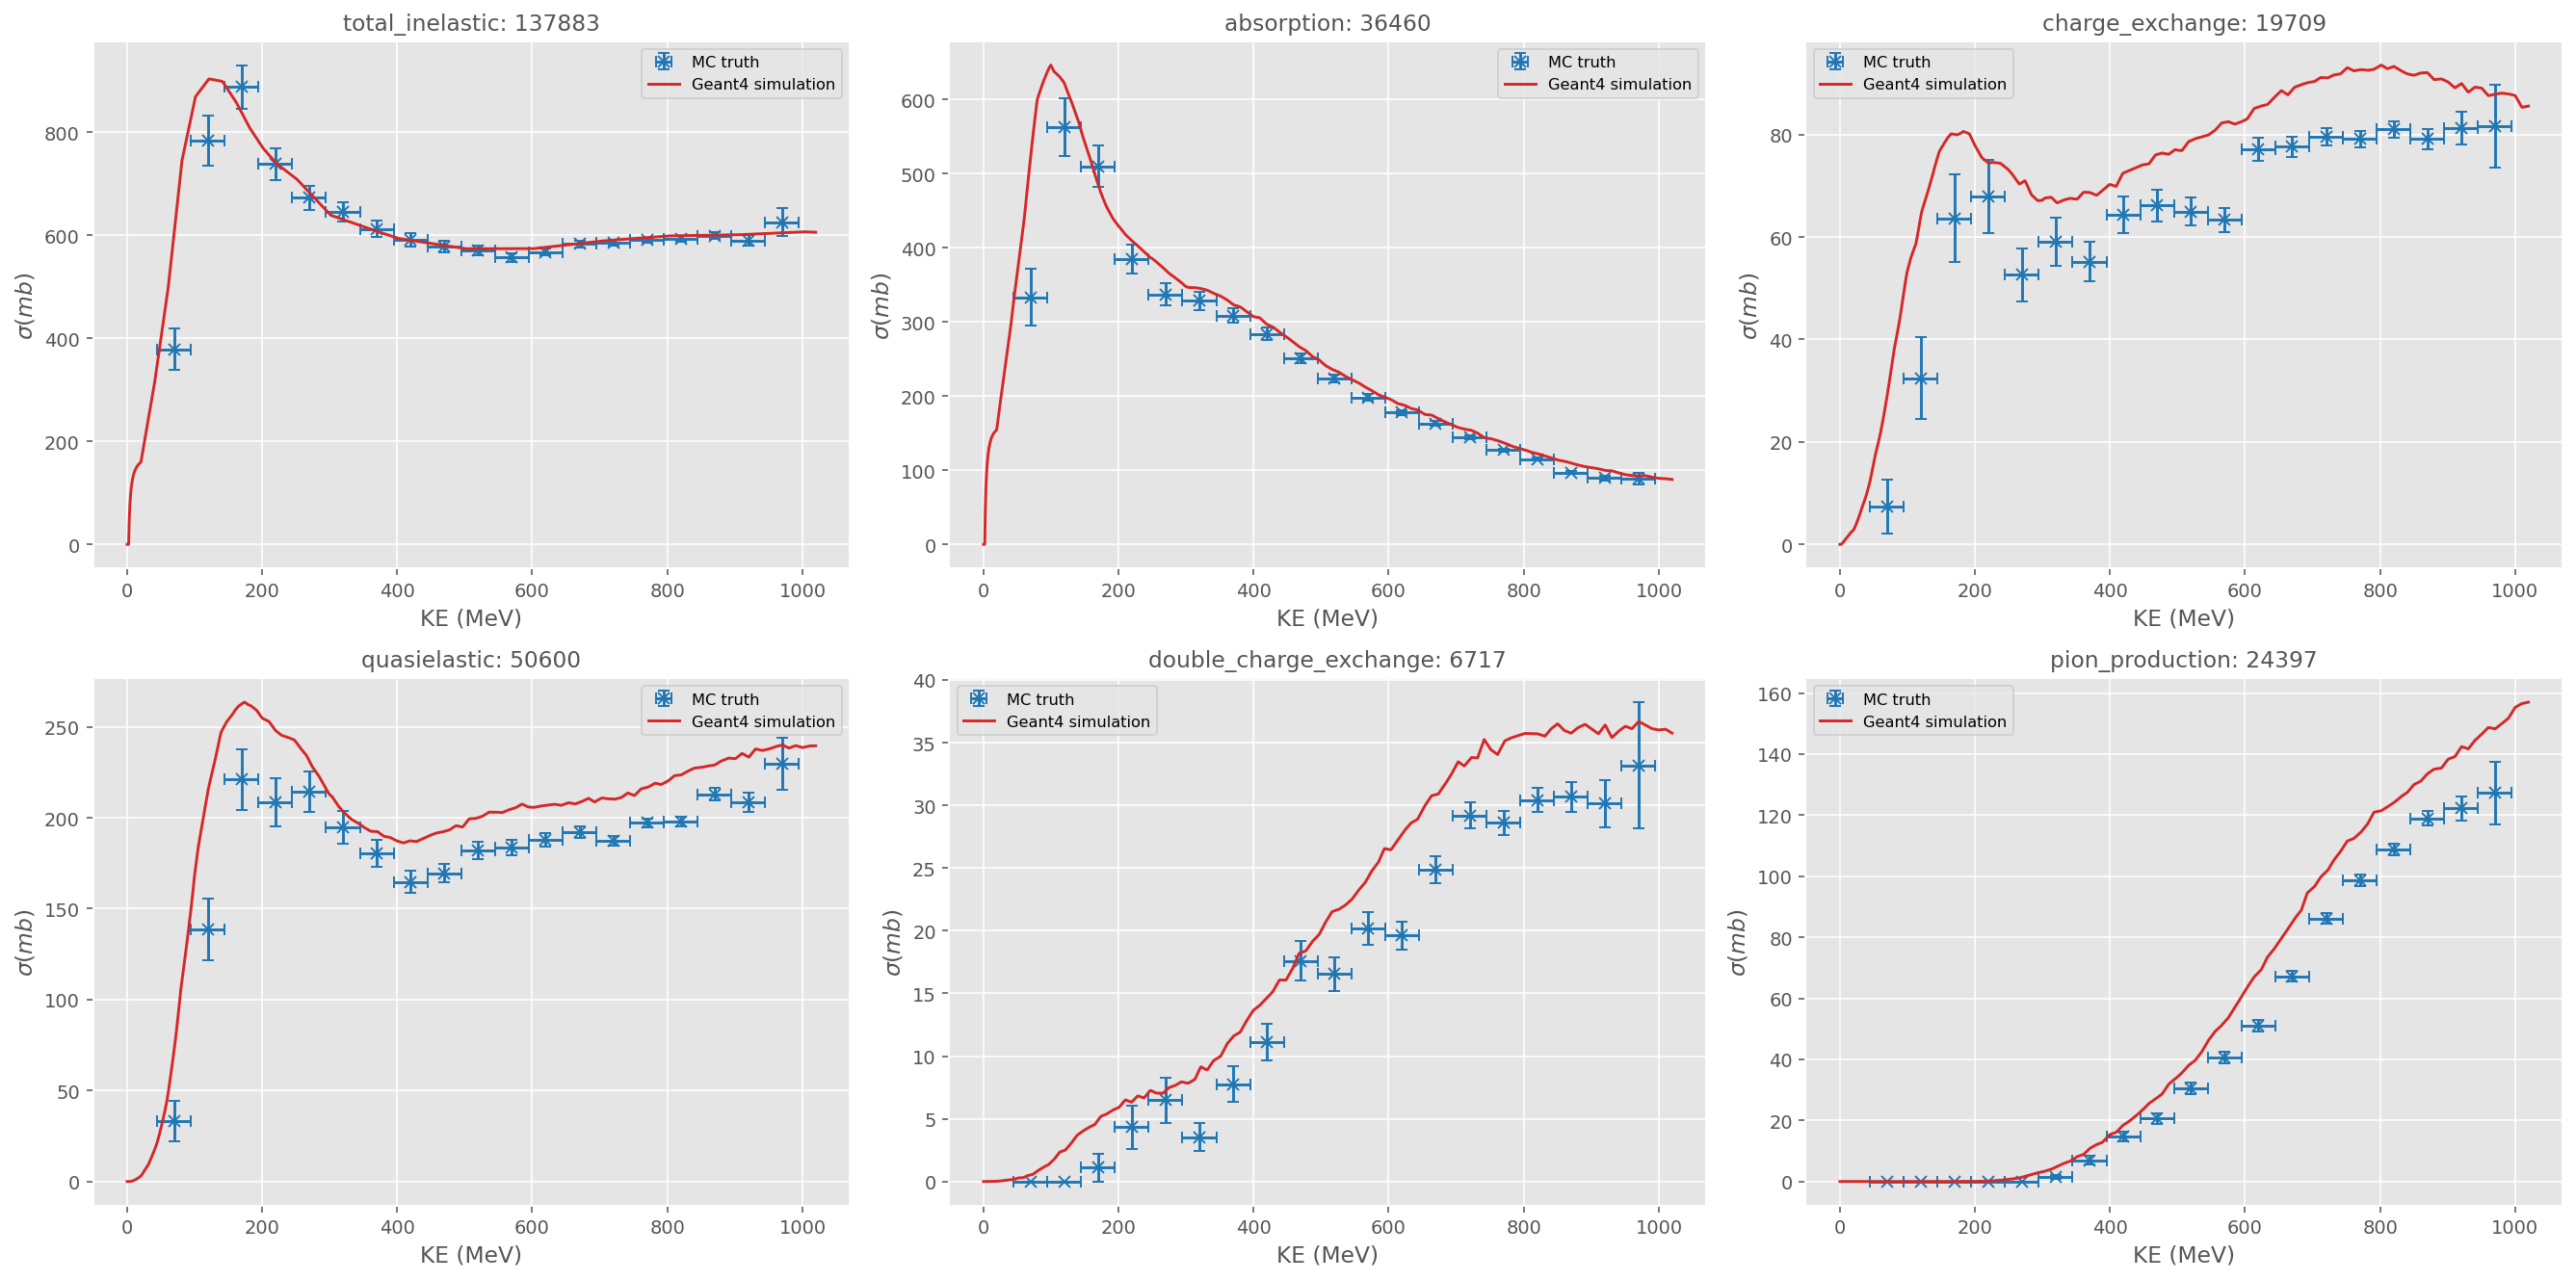

In [74]:
EsliceDemo(events, 0, 1020, 50)

# plt.setp(plt.gcf().axes[0], xlim = [1000, 2000], ylim = [0, 800])
# plt.setp(plt.gcf().axes[1], xlim = [1000, 2000], ylim = [0, 250])
# plt.setp(plt.gcf().axes[2], xlim = [1000, 2000], ylim = [0, 200])
# plt.setp(plt.gcf().axes[3], xlim = [1000, 2000], ylim = [0, 400])


In [374]:
"""
https://indico.fnal.gov/event/52248/
https://indico.fnal.gov/event/52663/contributions/232060/attachments/150781/194577/Hadron%20Meeting%201_13_22.pdf
https://indico.fnal.gov/event/52248/contributions/230130/attachments/150183/193605/Hadron%20Analysis%20Meeting%209%20Dec%202021.pdf
https://indico.fnal.gov/event/47844/contributions/208964/attachments/140192/176119/xs_validation_mcTrue_Prod4_02_18_21.pdf
https://indico.fnal.gov/event/54192/contributions/239696/attachments/154284/200404/Hadron%20Meeting%204-21-22.pdf
https://indico.fnal.gov/event/47844/contributions/208964/attachments/140192/176119/xs_validation_mcTrue_Prod4_02_18_21.pdf
https://indico.fnal.gov/event/55164/contributions/245011/attachments/156673/204588/pionXS_HadAna_220630.pdf

https://indico.fnal.gov/event/54122/contributions/239293/attachments/154088/200097/Hadron%20Meeting%204-14-22.pdf

https://indico.fnal.gov/event/53325/contributions/235193/attachments/152412/197326/pionXS_DRA_220223.pdf
"""

[None, None, None, None, None]

# Combined Study

In [83]:
def ThinSliceResults(events : Master.Data, slices : cross_section.Slices, regions : dict) -> dict:
    """ Do Thin slice study for MC truth.

    Args:
        events (Master.Data): events to look at
        slices (Slices): spatial slices
        regions (dict): truth regions

    Returns:
        dict: cross sections for each region.
    """
    interact_position = events.trueParticles.endPos.z[:, 0]
    xs = {}
    for r in regions:
        n_interact, n_incident = cross_section.ThinSlice.CountingExperiment(interact_position, regions[r], slices)
        xs[r] = cross_section.ThinSlice.CrossSection(n_incident, n_interact, slices.width/ 0.95)
    return xs


def ThinSliceMeanEnergy(events : Master.Data, slices : cross_section.Slices, regions : dict) -> tuple[ak.Array, ak.Array]:
    """ mean energy for each thin slice.

    Args:
        events (Master.Data): events to look at
        slices (Slices): spatial slices
        regions (dict): truth regions

    Returns:
        tuple[ak.Array, ak.Array]: _description_
    """
    traj_KE = events.trueParticles.beam_traj_KE
    traj_pos = events.trueParticles.beam_traj_pos.z

    mean_slice_energy = cross_section.ThinSlice.MeanSliceEnergy(traj_KE[regions["total_inelastic"]], traj_pos[regions["total_inelastic"]], slices)
    return mean_slice_energy


def EnergySliceResults(events : Master.Data, slices : cross_section.Slices, regions : dict) -> dict:
    """ Do Energy slice study for MC truth.

    Args:
        events (Master.Data): events to look at
        slices (Slices): energy slices
        regions (dict): truth regions

    Returns:
        dict: _description_
    """
    true_int_KE = events.trueParticles.beam_traj_KE[:, -2] # -1 is always zero for kinetic energy trajectory points, to take -2

    true_ffKE = ak.where(events.trueParticles.KE_front_face < 0, 999999, events.trueParticles.KE_front_face) # set KE to 999999 if the particle didn't reach the TPC.
    outside_tpc = true_ffKE >= 999999 # don't count events outside the TPC

    mean_dEdX = cross_section.EnergySlice.Slice_dEdX(energy_slices, Particle.from_pdgid(211))

    xs = {}
    for r in regions:
        n_interact, n_incident = cross_section.EnergySlice.CountingExperiment(true_int_KE, true_ffKE, outside_tpc, regions[r], energy_slices)
        xs[r] = cross_section.EnergySlice.CrossSection(n_interact, n_incident, mean_dEdX, energy_slices.width)

    return xs


In [ ]:
samples = {
    "1GeV" : LoadSample("work/ROOTFiles/PDSPAnalyser/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03.root", 149097),#149097
    "2GeV" : LoadSample("work/ROOTFiles/PDSPAnalyser/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03.root", 70774)#70774
}

cross_sections = cross_section.GeantCrossSections(energy_range = [0, 2000])
slices = cross_section.Slices(10, -10, 720) # cm
energy_slices = cross_section.Slices(20, 0, 2000, reversed = True) # MeV, slice 0 is high energy 

regions = {s : truth_regions(samples[s]) for s in samples}


/tmp/ipykernel_18833/4056152503.py:300: RuntimeWarning: invalid value encountered in divide
  xs = np.log(n_incident / (n_incident - n_interact)) # calculate a dimensionless cross section
/tmp/ipykernel_18833/4056152503.py:303: RuntimeWarning: invalid value encountered in divide
  v_interact = n_interact*(1- (n_interact/n_incident)) # binomial uncertainty
/tmp/ipykernel_18833/4056152503.py:305: RuntimeWarning: divide by zero encountered in divide
  xs_e = (1/n_incident) * (1/(n_incident - n_interact)) * (n_interact**2 * v_incident + n_incident**2 * v_interact)**0.5
/tmp/ipykernel_18833/4056152503.py:292: RuntimeWarning: invalid value encountered in divide
  mean_energy = sum_energy / counts
/tmp/ipykernel_18833/4056152503.py:294: RuntimeWarning: invalid value encountered in divide
  std_energy = np.sqrt(sum_energy_sqr/counts - 2 * mean_energy * sum_energy / counts + mean_energy**2) # expanded standard deviation so I can calulcate using the histograms


0 total_inelastic

1 absorption

2 charge_exchange

3 quasielastic

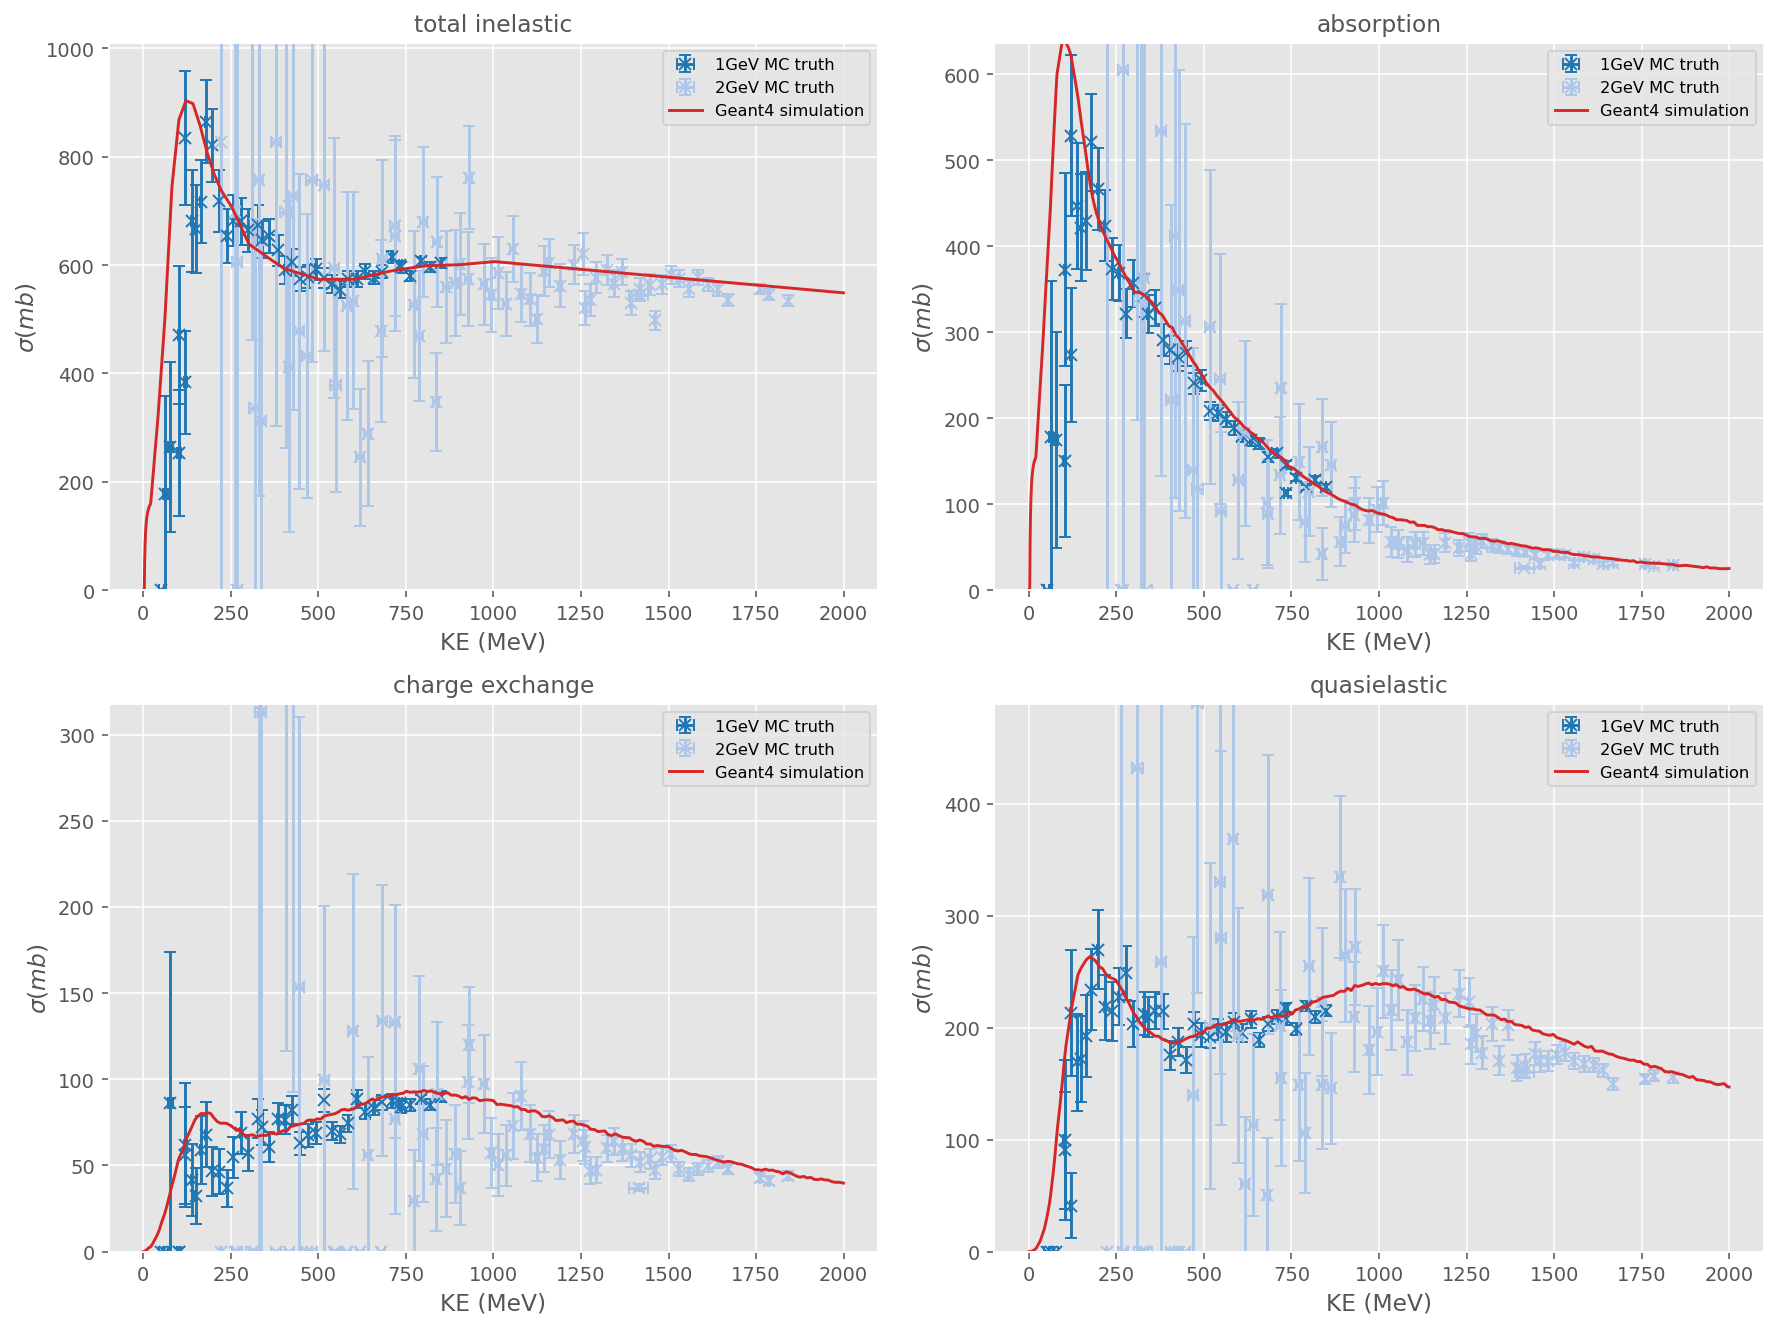

In [152]:
t_xs = {s: ThinSliceResults(samples[s], slices, regions[s]) for s in samples}
t_e = {s : ThinSliceMeanEnergy(samples[s], slices, regions[s]) for s in samples}

for i, r in Plots.IterMultiPlot(regions["1GeV"], True, False):
    print(i, r)
    for s in samples:
        Plots.Plot(t_e[s][0][1:-1], t_xs[s][r][0][1:-1], yerr = t_xs[s][r][1][1:-1], xerr = t_e[s][1][1:-1], xlabel = "average $\pi^{+}$ kinetic energy before interacting (MeV)", ylabel = "$\sigma$(mb)", linestyle = "", marker = "x", newFigure = False, label = s + " MC truth")
    cross_sections.Plot(r, label = "Geant4 simulation", color = "C6")
    plt.ylim(0, 0.7 * max(t_xs[s][r][0][1:-1]))

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:154: RuntimeWarning: invalid value encountered in sqrt
  beta = (1 - (1/gamma)**2)**0.5
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(
/tmp/ipykernel_18833/4056152503.py:300: RuntimeWarning: invalid value encountered in divide
  xs = np.log(n_incident / (n_incident - n_interact)) # calculate a dimensionless cross section
/tmp/ipykernel_18833/4056152503.py:300: RuntimeWarning: invalid value encountered in log
  xs = np.log(n_incident / (n_incident - n_interact)) # calculate a dimensionless cross section
/tmp/ipykernel_18833/4056152503.py:303: RuntimeWarning: invalid value encountered in divide
  v_interact = n_interact*(1- (n_interact/n_incident)) # binomial uncertainty
/tmp/ipykernel_18833/4056152503.py:305: RuntimeWarning: divide by zero encountered in divide
  xs_e

0 total_inelastic

1 absorption

2 charge_exchange

3 quasielastic

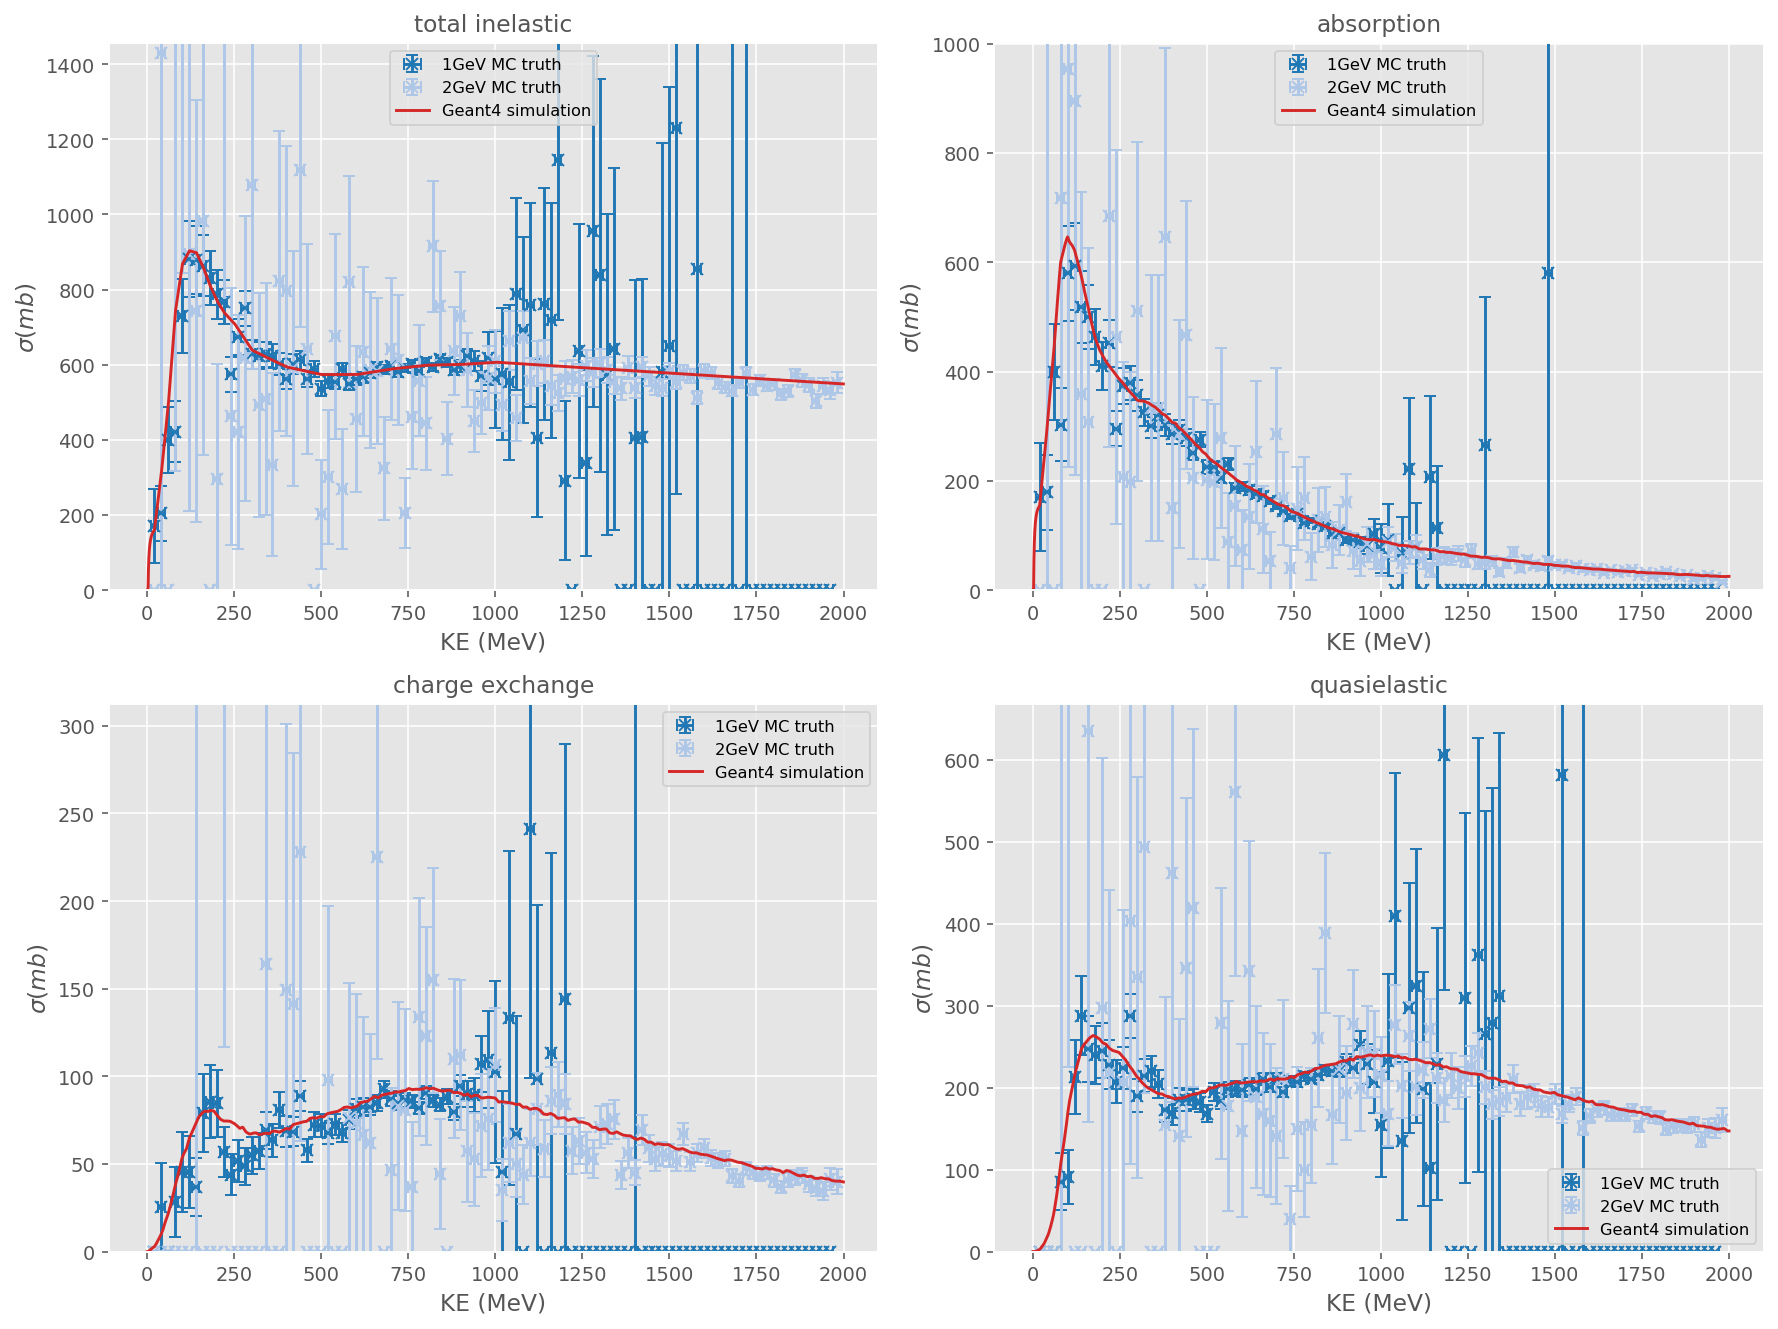

In [153]:
e_xs = {s: EnergySliceResults(samples[s], slices, regions[s]) for s in samples}

for i, r in Plots.IterMultiPlot(regions["1GeV"], True, False):
    print(i, r)
    for s in samples:
        Plots.Plot(energy_slices.pos[1:], e_xs[s][r][0][1:], yerr = e_xs[s][r][1][1:], xerr = energy_slices.width/2, xlabel = "average $\pi^{+}$ kinetic energy before interacting (MeV)", ylabel = "$\sigma$(mb)", linestyle = "", marker = "x", newFigure = False, label = s + " MC truth")
    cross_sections.Plot(r, label = "Geant4 simulation", color = "C6")
    plt.ylim(0, 0.7 * max(e_xs[s][r][0][1:]))

Create thin slices:
 - get all energy depositions made in the collection plane by the beam particle (in Analyser this is view2_IDEs)
 - get the wire pitch in the collection plane (this should be fixed)
 - slice the IDEs by the wire pitch:
   ```c++    
      std::map<int, std::vector<const sim::IDE*>> results; // create a map of slide ID numbers and the ides which fall into this slice

      for (size_t i = 0; i < ides.size(); ++i) {
         int slice_num = std::floor((ides[i]->z - (the_z0 - the_pitch/2.)) / the_pitch); // calculate the slice number for this IDE
         results[slice_num].push_back(ides[i]); // push the IDE into it's relevant slice
   ```
   The formula for calculating the slice number is
   $$
      slice\_num = floor\left(\frac{ide_{z} - z_{0} - \frac{1}{2}pitch}{pitch}\right)
   $$

Create thin tragets:
 - get the initial kinetic energy of the beam particle:
   $$
      KE_{ini} = \sqrt(p^{2} + m^{2}) - m;
   $$
   this is calculated in two ways (for some reason):
   ```c++
     double init_KE = sqrt(1.e6 * true_beam_startP*true_beam_startP +
                        true_beam_mass*true_beam_mass) - true_beam_mass;
   ```
   This uses simb:MCParticle properties
   ```c++
   init_KE = 1.e3 * true_beam_trajectory.E(i-1) - true_beam_mass;
   ```
   This uses the energy in the trajectory point before the first ide in the first slice.
 - loop thorugh all slices
 - calculate the energy deposited in this slice by summing energies of all ides in this slice
 - calculate the incidient energy in this slice, the first incident energy is $KE_{ini}$:
   $$
      KE_{inc, i} = KE_{inc, i-1} - \delta E_{i}
   $$

# Deconvolution/Convolution

Deconvolution (my preference is actually to call this convolution) in this context is used to see whether the discrepancy in the cross section measurement for the thin slice method is because of the spread due to the beam momentum, or some other effect (like statistics). The cross section from simulation is a function of kinetic energy, $\sigma(T_{\pi})$, but the cross section from the thin slice method is a function of average kinetic energy in a thin slice $\sigma(\left<T_{pi}\right>)$. So it is possible the thin slice method implemented in MC truth will not converge to the simulation curve because intrinsically it is not a direct relationship of cross section and kinetic energy, rather, it is convoluted by spread in the kinetic energy at each thin slice. The spread in Kinetic energy in a thin slice is partially due to the spread in the beam momentum i.e. if all particles in the simulation started at with the same momenta, they should have the same energy at each given position.

To test if this is the case, one can either:
 1. deconvolute the results from MC truth i.e. remove the Gaussian smearing bought about by the beam momentum spread. This is essentially unfolding the results and can be tricky.
 2. deconvlute (or I would say convolute) the simulation curve with the beam momentum spread.  

Picking option 2, the convolution of functions f and g, $f*g$ within a finite range ${0, T}$ is:

$$
(f*g)(t) = \int^{T}_{0}f(\tau)g(t-\tau)d\tau
$$

the integral can be done numerically, but the functions themselves must be determined. $g$ can be inferred from the distribution of true kinetic energy at the beam i.e. `events.trueparticles.StartE - particles.from_pdgid(211).mass`. $f$ is the function which produces the simulation curve, however, this is not readly known because the total cross section for LAr are interpolated from results from experimets using different materials, then the exclusive channels are extracted from the Bertini cascade model in Geant. So, in place of $f$ I use linear interpolation of the simulation points, perhaps an empirical formula would suffice.

In [408]:
class square_function:
    def __init__(self, width : float, center : float, scale : float = 1):
        self.l = width
        self.x0 = center
        self.a = scale
        return
    def __call__(self, x : any) -> any:
        return np.where((x > (self.x0 - (self.l/2))) & (x < (self.x0 + (self.l/2))), self.a, 0)

class sawtooth:
    def __init__(self, gradient, center, intercept):
        self.m = gradient
        self.x0 = center
        self.c = intercept
        return
    def __call__(self, x : any) -> any:
        left = self.m * (x - self.x0) + self.c
        right = -self.m * (x - self.x0) + self.c

        y = np.where(left >= self.c, right, left)
        y = np.where(left < 0, 0, y)
        y = np.where(right < 0, 0, y)
        return y

class half_sawtooth:
    def __init__(self, gradient, center, intercept):
        self.m = gradient
        self.x0 = center
        self.c = intercept
        return
    def __call__(self, x : any) -> any:
        y = self.m * (x - self.x0) + self.c
        y = np.where(y < 0, 0, y)
        y = np.where(y > self.c, 0, y)
        return y

class gaussian_pdf:
    def __init__(self, mu : float, sigma : float) -> None:
        self.mu = mu
        self.sigma = sigma
        return
    def __call__(self, x : any) -> any:
        coefficient = 1 / (self.sigma * np.sqrt(2 * np.pi))
        exponent = -(x - self.mu) ** 2 / (2 * self.sigma ** 2)
        return coefficient * np.exp(exponent)

def Convolve(x : np.array, f : callable, g : callable, integral_range : list, nsteps : int):
    if nsteps < len(x):
        print("nsteps should be larger or at least the same size as x")
    t = np.linspace(*integral_range, nsteps)
    h = []
    for i in x:
        h.append(np.trapz(f(t) * g(i - t), t)) # replace with more accurate algorithm?
    return np.array(h)


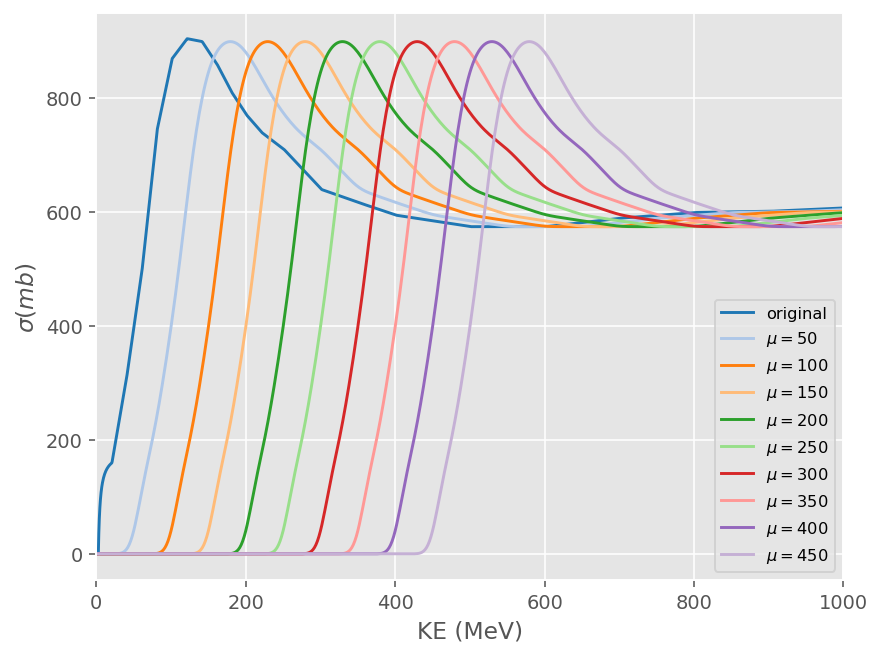

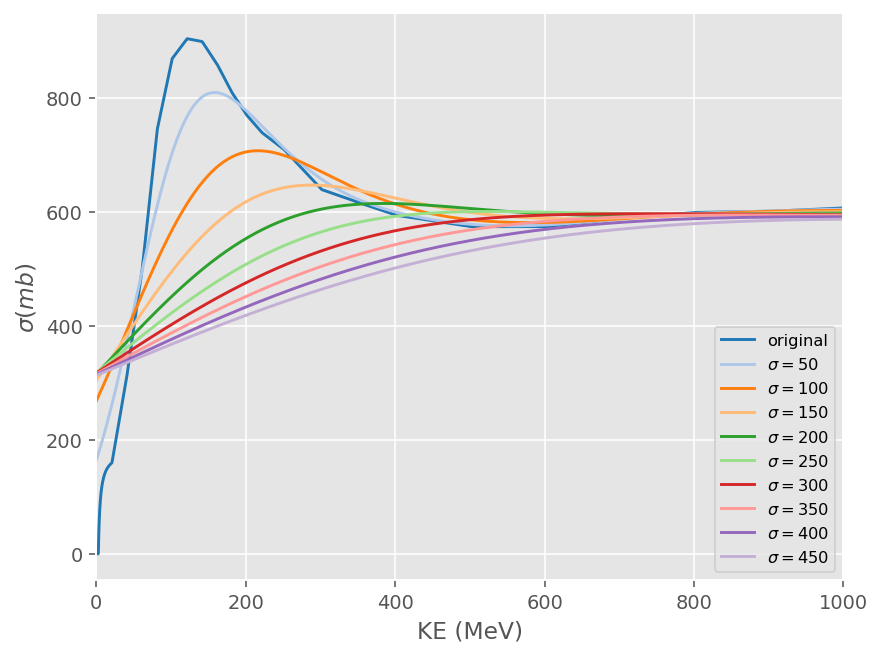

In [406]:
# use a normalised Gaussian to ensure the convulted function has the correct amplitude
def gaussian_pdf(x, mean, std_dev):
    coefficient = 1 / (std_dev * np.sqrt(2 * np.pi))
    exponent = -(x - mean) ** 2 / (2 * std_dev ** 2)
    return coefficient * np.exp(exponent)

def CrossSectionConvolution(xs : cross_section.GeantCrossSections, channel : str, mu : float, sigma : float, int_step : float = 10, conv_step : float = 10, energy_range : list = [0, 1000], label = None):

    def f(x, t): # integrand
        return p(x) * gaussian_pdf(t - x, mu, sigma)

    sampling_range = [min(xs.KE), max(xs.KE)]
    points = np.arange(*sampling_range, int_step)
    p = interp1d(xs.KE, getattr(xs, channel)) # interpolate between xs values here.

    h = []
    x = np.arange(*energy_range, conv_step)
    for t in x:
        s = np.trapz(f(points, t), points)
        h.append(s)
    Plots.Plot(x, h, newFigure = False, label = label)
    plt.xlim(*energy_range)
    return x, h

cross_sections = cross_section.GeantCrossSections()

values = np.arange(50, 500, 50)
plt.figure()
cross_sections.Plot("total_inelastic", label = "original")
for v in values:
    _ = CrossSectionConvolution(cross_sections, "total_inelastic", v, 10, conv_step = 2, label = "$\mu=$" + str(v))
plt.figure()
cross_sections.Plot("total_inelastic", label = "original")
for v in values:
    _ = CrossSectionConvolution(cross_sections, "total_inelastic", 0, v, conv_step = 2, label = "$\sigma=$" + str(v))


### Beam momentum

In [214]:
true_beam_KE = np.array(events.trueParticles.energy[:, 0] - Particle.from_pdgid(211).mass)

/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in power
  result = getattr(ufunc, method)(


In [1]:
h, edges = np.histogram(np.array(true_beam_KE[~np.isnan(true_beam_KE)]), bins = 100, range = sorted([np.nanpercentile(true_beam_KE, 1), np.nanpercentile(true_beam_KE, 99)]))
popt, _ = Fitting.Fit((edges[1:] + edges[:-1]) / 2, h, np.sqrt(h), Fitting.gaussian, plot = True, xlabel = "$T^{true}_{\pi^{+}}$", ylabel = "counts")

# expteced_peak = (1000**2 - Particle.from_pdgid(211).mass**2)**0.5 - Particle.from_pdgid(211).mass # beam should be 1000 MeV pions, so, should be centred at ~850 MeV KE.
# plt.axvline(expteced_peak, color = "black", linestyle = "--")

NameError: name 'np' is not defined

In [216]:
regions = truth_regions(events)
xs = ThinSliceResults(events, cross_section.Slices(10, -10, 720), regions)
e = ThinSliceMeanEnergy(events, cross_section.Slices(10, -10, 720), regions)

/tmp/ipykernel_18900/934252342.py:267: RuntimeWarning: invalid value encountered in divide
  xs = np.log(n_incident / (n_incident - n_interact)) # calculate a dimensionless cross section
/tmp/ipykernel_18900/934252342.py:270: RuntimeWarning: invalid value encountered in divide
  v_interact = n_interact*(1- (n_interact/n_incident)) # binomial uncertainty
/tmp/ipykernel_18900/934252342.py:272: RuntimeWarning: divide by zero encountered in divide
  xs_e = (1/n_incident) * (1/(n_incident - n_interact)) * (n_interact**2 * v_incident + n_incident**2 * v_interact)**0.5
/tmp/ipykernel_18900/934252342.py:249: RuntimeWarning: invalid value encountered in divide
  mean_energy = sum_energy / counts
/tmp/ipykernel_18900/934252342.py:251: RuntimeWarning: invalid value encountered in divide
  std_energy = np.sqrt(sum_energy_sqr/counts - 2 * mean_energy * sum_energy / counts + mean_energy**2) # expanded standard deviation so I can calulcate using the histograms


(0.0, 1050.0)

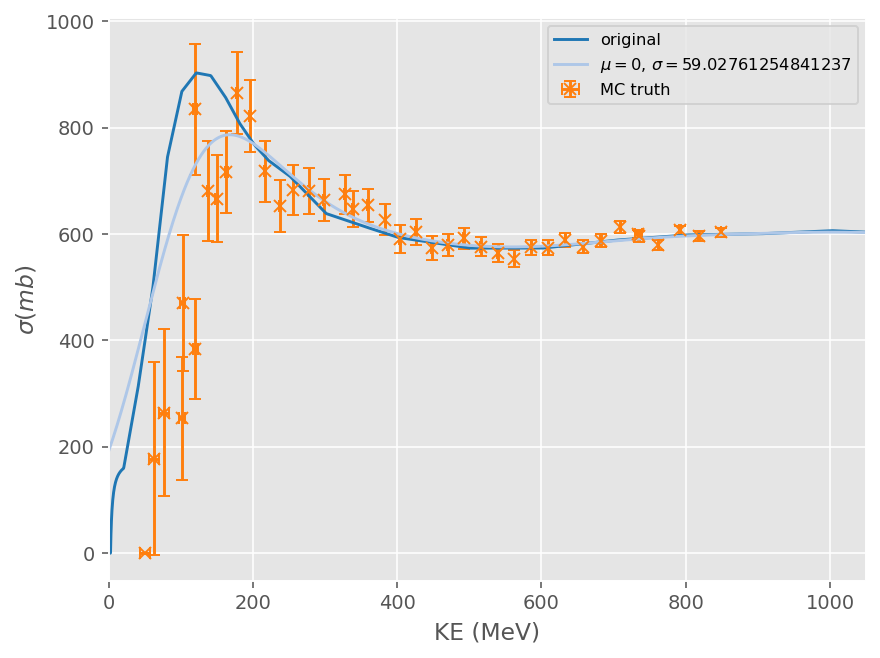

In [409]:
cross_sections = cross_section.GeantCrossSections()
p = interp1d(cross_sections.KE, cross_sections.total_inelastic)
KE_v = np.linspace(1, 1001, 100)
h = Convolve(cross_sections.KE, p, gaussian_pdf(0, popt[2]), [min(cross_sections.KE), max(cross_sections.KE)], len(cross_sections.KE))
h_2 = Convolve(cross_sections.KE, p, gaussian_pdf(8.5, popt[2]), [min(cross_sections.KE), max(cross_sections.KE)], len(cross_sections.KE))

plt.figure()
cross_sections.Plot("total_inelastic", label = "original")
Plots.Plot(cross_sections.KE, h, label = "$\mu = $" + str(0) + ", $\sigma =$" + str(popt[2]), newFigure = False)
# Plots.Plot(cross_sections.KE, h_2, label = "$\mu = $" + str(8.5) + ", $\sigma =$" + str(popt[2]), newFigure = False)
Plots.Plot(e[0][1:-1], xs["total_inelastic"][0][1:-1], yerr = xs["total_inelastic"][1][1:-1], xerr = e[1][1:-1], marker = "x", linestyle = "", label = "MC truth", newFigure = False)

plt.xlim(0, 1050)


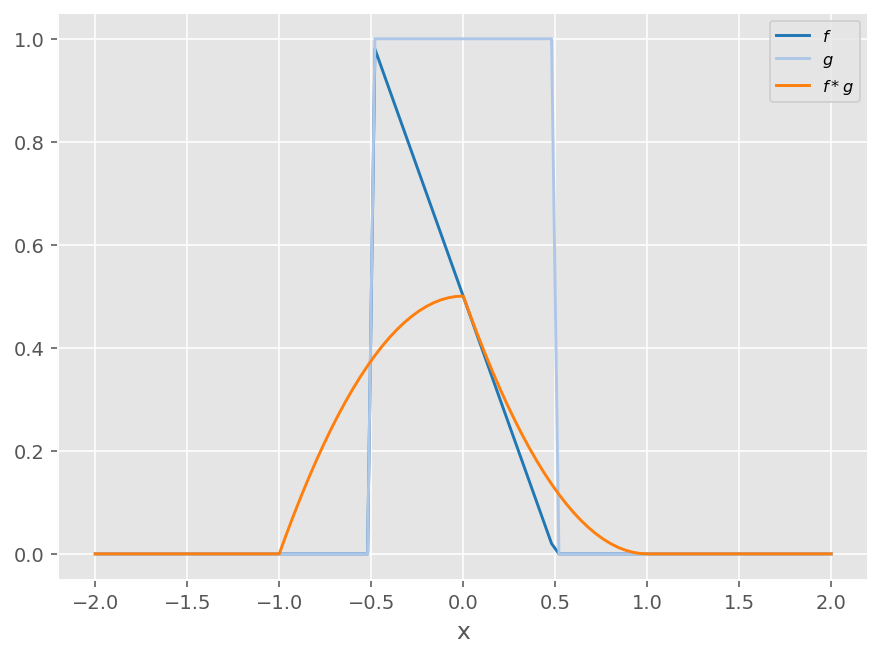

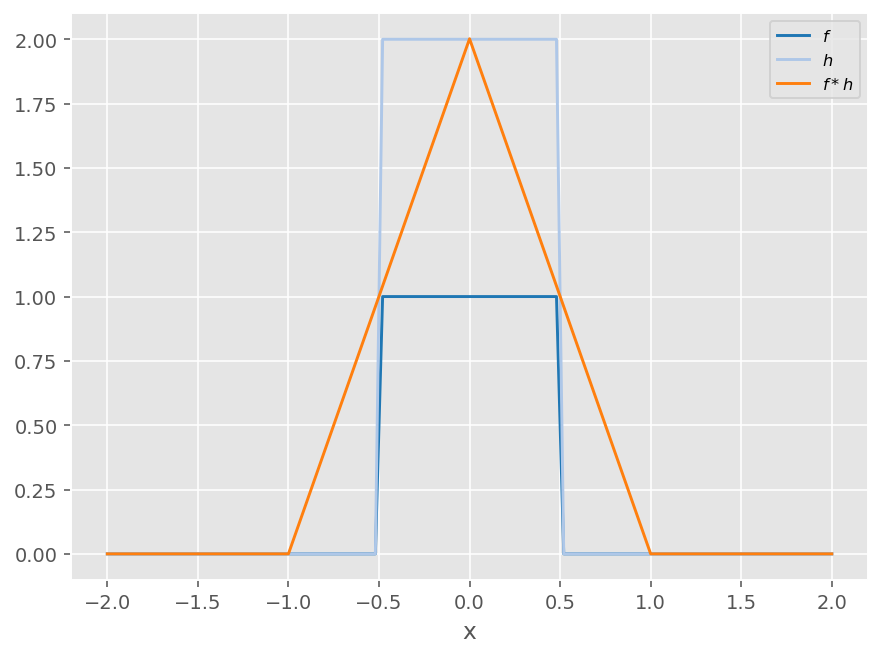

In [220]:
x = np.linspace(-2, 2, 101)

f = square_function(1, 0)
g = half_sawtooth(-1, -0.5, 1)
h = square_function(1, 0, 2)

Plots.Plot(x, g(x), label = "$f$")
Plots.Plot(x, f(x), newFigure = False, label = "$g$")
Plots.Plot(x, Convolve(x, f, g, [-2, 2], 1000), xlabel = "x", label = "$f*g$", newFigure = False)

Plots.Plot(x, f(x), label = "$f$")
Plots.Plot(x, h(x), newFigure = False, label = "$h$")
Plots.Plot(x, Convolve(x, f, h, [-10, 10], 1000), xlabel = "x", label = "$f*h$", newFigure = False)

# Mean of the cross sections vs cross section of the means

/tmp/ipykernel_19024/599249844.py:250: RuntimeWarning: invalid value encountered in divide
  mean_energy = sum_energy / counts
/tmp/ipykernel_19024/599249844.py:252: RuntimeWarning: invalid value encountered in divide
  std_energy = np.divide(sum_energy_sqr, counts) - mean_energy**2
/tmp/ipykernel_19024/599249844.py:270: RuntimeWarning: invalid value encountered in divide
  xs = np.log(n_incident / (n_incident - n_interact)) # calculate a dimensionless cross section
/tmp/ipykernel_19024/599249844.py:273: RuntimeWarning: invalid value encountered in divide
  v_interact = n_interact*(1- (n_interact/n_incident)) # binomial uncertainty
/tmp/ipykernel_19024/599249844.py:275: RuntimeWarning: divide by zero encountered in divide
  xs_e = (1/n_incident) * (1/(n_incident - n_interact)) * (n_interact**2 * v_incident + n_incident**2 * v_interact)**0.5


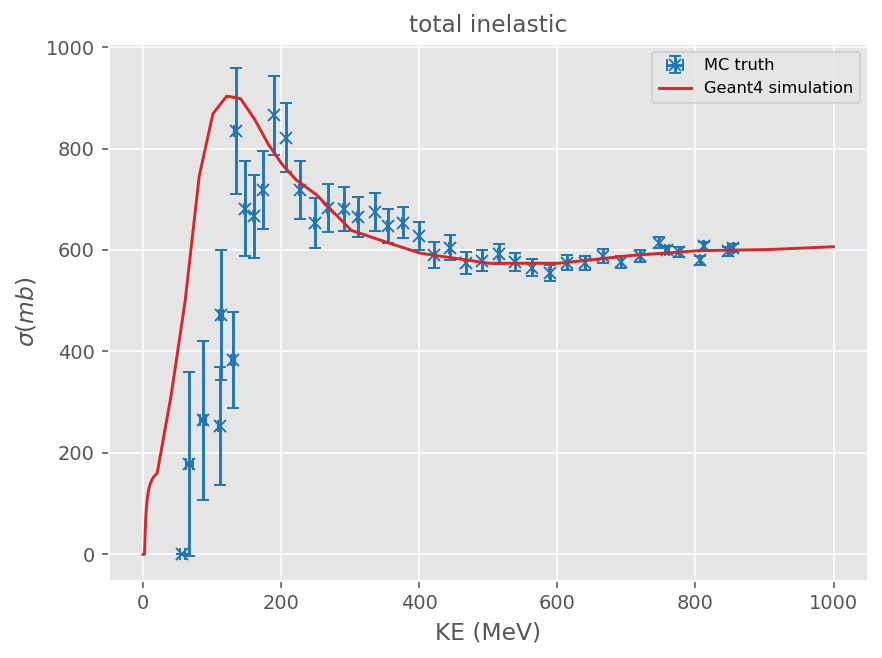

In [94]:
cross_sections = cross_section.GeantCrossSections(energy_range = [0, 1000]) # get cross sections from simulation

slices = cross_section.Slices(10, -10, 720) # define spatial slices

interact_position = events.trueParticles.endPos.z[:, 0] # get interaction vertex z position

traj_KE = events.trueParticles.beam_traj_KE[:, :-1] # get beam particle kinetic energy at each trajectory point from simulation
traj_pos = events.trueParticles.beam_traj_pos.z[:, :-1] # get beam particle z at each trajectory point from simulation 

regions = truth_regions(events) # get trtuh regions
mean_slice_energy, mean_error_slice_energy = cross_section.ThinSlice.MeanSliceEnergy(traj_KE[regions["total_inelastic"]], traj_pos[regions["total_inelastic"]], slices) # get average particle energy in each slice

# #* evalutate and plot for each exclusive cross section
# for i, region in Plots.IterMultiPlot(regions):
#     print(f"evaluating {region} region")

n_interact, n_incident = cross_section.ThinSlice.CountingExperiment(interact_position, regions["total_inelastic"], slices)
xs = cross_section.ThinSlice.CrossSection(n_incident, n_interact, slices.width/ 0.95)
Plots.Plot(mean_slice_energy[1:-1], xs[0][1:-1], yerr = xs[1][1:-1], xerr = mean_error_slice_energy[1:-1], xlabel = "average $\pi^{+}$ kinetic energy before interacting (MeV)", ylabel = "$\sigma$(mb)", linestyle = "", marker = "x", newFigure = False, label = "MC truth")
cross_sections.Plot("total_inelastic", label = "Geant4 simulation", color = "C6")


/tmp/ipykernel_19024/1115668450.py:13: RuntimeWarning: invalid value encountered in divide
  mean_xs = np.divide(sum_xs, counts)
/tmp/ipykernel_19024/1115668450.py:16: RuntimeWarning: invalid value encountered in divide
  var_energy = np.divide(sum_xs_sqr, counts) - mean_xs**2
/tmp/ipykernel_19024/1115668450.py:17: RuntimeWarning: invalid value encountered in sqrt
  error_mean_xs = (np.divide(var_energy, counts))**0.5


(0.0, 1000.0)

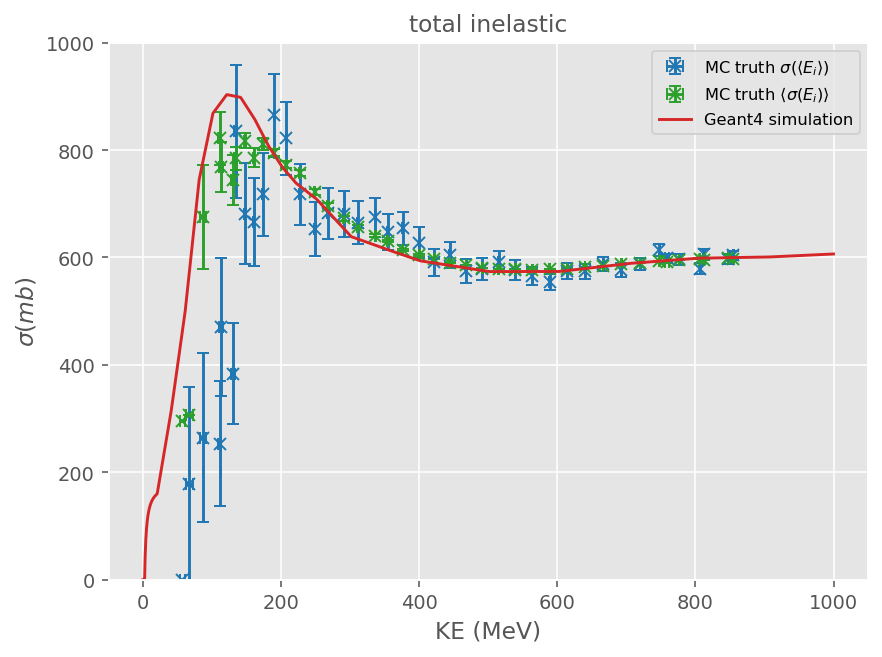

In [95]:
def MeanSliceXS(energy : ak.Array, endPos : ak.Array, slices : cross_section.Slices) -> tuple[ak.Array, ak.Array]:
    xs_func = interp1d(cross_sections.KE, cross_sections.total_inelastic, fill_value = "extrapolate")

    beam_traj_slice = ak.ravel(slices.pos_to_num(endPos))
    beam_traj_xs = xs_func(ak.ravel(energy))
    slice_nums = slices.num

    counts = np.histogram(beam_traj_slice, slice_nums)[0] # histogram of positions will give the counts

    sum_xs = np.histogram(beam_traj_slice, slice_nums, weights = beam_traj_xs)[0] # total energy in each bin if you weight by energy
    sum_xs_sqr = np.histogram(beam_traj_slice, slice_nums, weights = beam_traj_xs**2)[0] # same as above

    mean_xs = np.divide(sum_xs, counts)

    # var_energy = np.divide(sum_xs_sqr, counts) - np.divide(2 * mean_xs * sum_xs, counts) + mean_xs**2 # expanded variance so I can calulcate using the histograms
    var_energy = np.divide(sum_xs_sqr, counts) - mean_xs**2
    error_mean_xs = (np.divide(var_energy, counts))**0.5
    # error_mean_xs = np.divide((sum_xs_sqr)**0.5, counts)
    
    return mean_xs, error_mean_xs

mean_xs, mean_xs_error = MeanSliceXS(traj_KE[regions["total_inelastic"]][:, -1], traj_pos[regions["total_inelastic"]][:, -1], slices) # only take the last index because this represnets the interacting kinetic energy
Plots.Plot(mean_slice_energy[1:-1], xs[0][1:-1], yerr = xs[1][1:-1], xerr = mean_error_slice_energy[1:-1], xlabel = "average $\pi^{+}$ kinetic energy before interacting (MeV)", ylabel = "$\sigma$(mb)", linestyle = "", marker = "x", newFigure = False, label = "MC truth $\sigma(\left< E_{i} \\right>)$")
Plots.Plot(mean_slice_energy[1:-1], mean_xs[1:-1], yerr = mean_xs_error[1:-1], xerr = mean_error_slice_energy[1:-1], color = "C4", linestyle = "", marker = "x", newFigure = False, label = "MC truth $\left< \sigma(E_{i}) \\right>$")
cross_sections.Plot("total_inelastic", label = "Geant4 simulation", color = "C6")
plt.ylim(0, 1000)


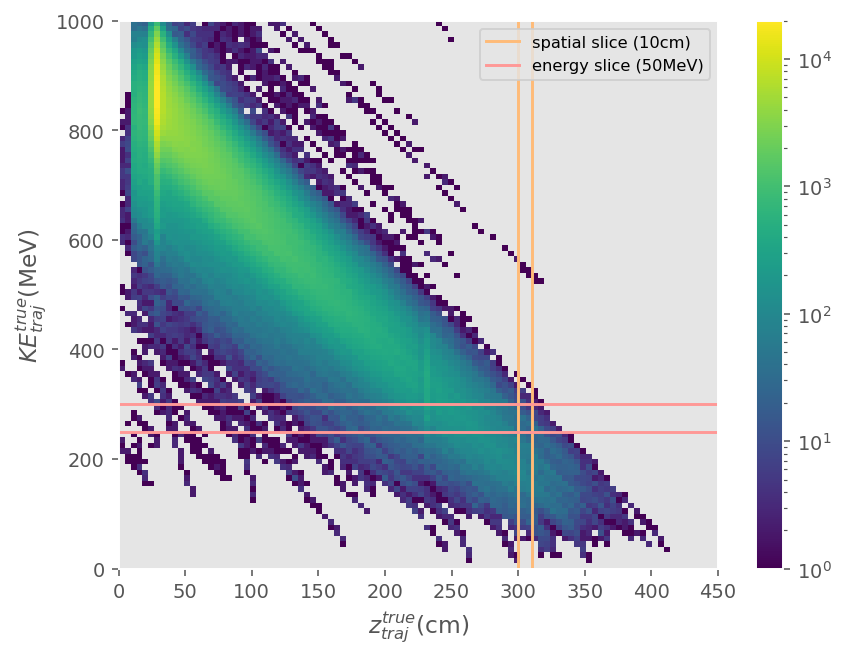

In [120]:
Plots.PlotHist2D(ak.ravel(traj_pos[regions["total_inelastic"]]), ak.ravel(traj_KE[regions["total_inelastic"]]), x_range = [0, 450], y_range = [0, 1000], xlabel = "$z^{true}_{traj}$(cm)", ylabel = "$KE^{true}_{traj}$(MeV)")

plt.axvline(300, color = "C3")
plt.axvline(310, color = "C3", label = "spatial slice (10cm)")

plt.axhline(250, color = "C7")
plt.axhline(300, color = "C7", label = "energy slice (50MeV)")

plt.legend(loc = "upper right")

In [90]:
import matplotlib.backends.backend_pdf


with matplotlib.backends.backend_pdf.PdfPages("thin_slice_xs_bins.pdf") as pdf:
    xs_func = interp1d(cross_sections.KE, cross_sections.total_inelastic, fill_value = "extrapolate")
    # for i, s in Plots.IterMultiPlot(list(slices)):
    for i, s in enumerate(list(slices)):
        mask = slices.pos_to_num(traj_pos[regions["total_inelastic"]][:, -1]) == s.num
        energy = traj_KE[regions["total_inelastic"]][:, -1][mask]
        Plots.PlotHist(xs_func(ak.ravel(energy)), title = s.__str__(), range = [150, 900], xlabel = "$\sigma$(mb)")
        pdf.savefig()
        plt.close()

with matplotlib.backends.backend_pdf.PdfPages("thin_slice_KE_int_bins.pdf") as pdf:
    xs_func = interp1d(cross_sections.KE, cross_sections.total_inelastic, fill_value = "extrapolate")
    for i, s in enumerate(list(slices)):
        mask = slices.pos_to_num(traj_pos[regions["total_inelastic"]][:, -1]) == s.num
        energy = traj_KE[regions["total_inelastic"]][:, -1][mask]

        Plots.PlotHist(ak.ravel(energy), title = s.__str__(), range = [0, 1100], xlabel = "$KE^{true}_{int}$ (MeV)")
        pdf.savefig()
        plt.close()

In [78]:
energies = []
traj_slice = slices.pos_to_num(traj_pos[regions["total_inelastic"]])
for s in slices:
    mask = traj_slice == s.num
    energy = traj_KE[regions["total_inelastic"]][mask]
    energies.append(np.mean(energy))
energies.pop(-2)
energies = np.array(energies)

m, e = cross_section.ThinSlice.MeanSliceEnergy(traj_KE[regions["total_inelastic"]], traj_pos[regions["total_inelastic"]], slices)
print(m - energies)

/tmp/ipykernel_19024/976811188.py:250: RuntimeWarning: invalid value encountered in divide
  mean_energy = sum_energy / counts
/tmp/ipykernel_19024/976811188.py:252: RuntimeWarning: invalid value encountered in divide
  std_energy = np.sqrt(np.divide(sum_energy, counts) - mean_energy**2)
/tmp/ipykernel_19024/976811188.py:252: RuntimeWarning: invalid value encountered in sqrt
  std_energy = np.sqrt(np.divide(sum_energy, counts) - mean_energy**2)
/tmp/ipykernel_19024/976811188.py:254: RuntimeWarning: invalid value encountered in divide
  error_mean_energy = np.divide((sum_energy_sqr)**0.5, counts)


[ 3.41060513e-13  1.55523594e-10  1.19371180e-11 -3.63797881e-12
  1.81898940e-12  1.58024704e-11 -4.77484718e-12 -1.09139364e-11
  4.54747351e-12  1.31876732e-11 -1.18234311e-11  8.07176548e-12
  1.96678229e-11 -6.48014975e-12 -7.50333129e-12  5.34328137e-12
 -2.48974175e-11  2.39310793e-11  2.21689334e-12 -1.79056769e-11
 -1.58024704e-11 -3.80850906e-12 -1.92699190e-11  8.44124770e-11
 -9.89643922e-11  1.38356882e-10 -2.80806489e-11 -1.50976120e-10
  1.31024080e-11  1.30199851e-10 -2.01708872e-10  2.63156608e-10
 -3.33983508e-10  3.10933501e-10 -4.69015049e-10 -5.31343858e-10
  8.33324520e-10  1.25154997e-10 -7.57593455e-09  1.76730168e-08
 -2.00680574e-08  2.25942784e-08             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
  6.42330633e-11]